- [3.1 Overview](#3_1)
- [3.2 Loading and Imports](#3_2)
- [3.3 Exploring Data](#3_3)
    - [3.3.1 Industry, Job Level, Location Background](#3_3_1)
        - [3.3.1.1 Firm and Industries](#3_3_1_1)
        - [3.3.1.2 Job Level](#3_3_1_2)
        - [3.3.1.3 Location](#3_3_1_3)
    - [3.3.2 Job Ratings](#3_3_2)
    - [3.3.3 Job Reviews](#3_3_3)
- [3.4 Summary](#3_4)
    - [3.4.1 Word Cloud](#3_4_1)
- [3.5 Export](#3_5)

### 3.1 Overview <a id = '3_1'></a>
For EDA, I questions I'd like to answer:
- What variable has the highest effect on satisfaction rate?
- What are the key words associated for satisfaction and dissastifaction rate?
- How does this vary for different industries? Positions?

### 3.2 Loading and Imports

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy

In [346]:
df = pd.read_csv('CleanedData/clean_data.csv')
df.head(5)

firm                   job_title            status years  \
0  IBM                   Test Lead   Former Employee     1   
1  IBM  Associate Systems Engineer   Former Employee   0.5   
2  IBM            Program Director  Current Employee   0.5   
3  IBM  Technical Support Engineer  Current Employee     3   
4  IBM    Senior Software Engineer  Current Employee   NaN   

                     location  overall_rating  work_life_balance  \
0                 Halifax, NS               1                1.0   
1                   Bangalore               3                4.0   
2                   Tampa, FL               2                1.0   
3                   Hyderābād               1                3.0   
4  Research Triangle Park, NC               3                5.0   

   culture_values  career_opp  comp_benefits  senior_mgmt  \
0             1.0         4.0            2.0          1.0   
1             3.0         3.0            1.0          2.0   
2             1.0         1.0            2.0          1.0   
3             1.0         1.0            3.0          1.0   
4             4.0         4.0            4.0          2.0   

                                            headline  \
0                             Very bad place to work   
1                          Associate System Engineer   
2  IBM - the people are great - Company could car...   
3                                   Soulless company   
4                                an OK place to work   

                                                pros  \
0          IBM provides lot of training to employees   
1  Good Work Life Balance, Cool Projects.Employee...   
2  Amazing, talented, people. Everything that is ...   
3                     Good to have it on your resume   
4  tech leader, constant encouragement to continu...   

                                                cons  \
0  Salary, They treat employees very bad. Employe...   
1  NO HIKE. AN IBM EMPLOYEE DOESN'T  HAVE RIGHT T...   
2  IBM the corporation does not value their emplo...   
3  - no culture \r\n- no real career path\r\n- yo...   
4  executive level management will cut budgets an...   

                                      processed_text  
0  bad place work IBM provide lot training employ...  
1  associate System Engineer Good Work Life Balan...  
2  IBM people great company care amazing talented...  
3  soulless company Good resume culture \r\n real...  
4  ok place work tech leader constant encourageme...

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150220 entries, 0 to 150219
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   firm               150220 non-null  object 
 1   job_title          150186 non-null  object 
 2   status             82281 non-null   object 
 3   years              57757 non-null   object 
 4   location           150220 non-null  object 
 5   overall_rating     150220 non-null  int64  
 6   work_life_balance  150220 non-null  float64
 7   culture_values     150220 non-null  float64
 8   career_opp         150220 non-null  float64
 9   comp_benefits      150220 non-null  float64
 10  senior_mgmt        150220 non-null  float64
 11  headline           150220 non-null  object 
 12  pros               150220 non-null  object 
 13  cons               150220 non-null  object 
 14  processed_text     150220 non-null  object 
dtypes: float64(5), int64(1), object(9)
memory usage: 17

## 3.3 Exploring the Data <a id="3_3"></a>

### 3.3.1 Industry, Job, Location analysis <a id="3_3_1"></a>
- We have info of location, firm, and job titles of employees
- To what extent does these effect our employee satisfaction of these places?

#### 3.3.1.1 Firm Industries <a id="3_3_1_3"></a>
- A good place to start is to start by classifying every industry, so we can see industry trends later on

In [348]:
### Map to each industry, with help of GPT 
# Feature engineering
industry_mapping = {
    'IBM': 'Tech',
    'McDonald-s': 'Food',
    'Google': 'Tech',
    'Deloitte': 'Consulting',
    'SAP': 'Tech',
    'Apple': 'Tech',
    'Citi': 'Financial Services',
    'HSBC-Holdings': 'Financial Services',
    'KPMG': 'Consulting',
    'J-P-Morgan': 'Financial Services',
    'Microsoft': 'Tech',
    'PwC': 'Consulting',
    'Oracle': 'Tech',
    'EY': 'Consulting',
    'Barclays': 'Financial Services',
    'American-Express': 'Financial Services',
    'Salesforce': 'Tech',
    'Thomson-Reuters': 'Media',
    'Vodafone': 'Telecommunications',
    'Goldman-Sachs': 'Financial Services',
    'Morgan-Stanley': 'Financial Services',
    'Marriott-International': 'Hospitality',
    'Tesco': 'Retail',
    'Deutsche-Bank': 'Financial Services',
    'BNY-Mellon': 'Financial Services',
    'BT': 'Telecommunications',
    'Booking-com': 'Tech',
    'CBRE': 'Real Estate',
    'Hilton': 'Hospitality',
    'McKinsey-and-Company': 'Consulting',
    'Unilever': 'Consumer Goods',
    'LinkedIn': 'Tech',
    'GlaxoSmithKline': 'Pharmaceuticals',
    'Bloomberg-L-P': 'Media',
    'Bain-and-Company': 'Consulting',
    'BNP-Paribas': 'Financial Services',
    'Capita': 'Consulting',
    'J-Sainsbury': 'Retail',
    'NHS': 'Healthcare',
    'Aon': 'Consulting',
    'Pearson': 'Education',
    'Marks-and-Spencer': 'Retail',
    'Willis-Towers-Watson': 'Consulting',
    'Primark': 'Retail',
    'Hyatt': 'Hospitality',
    'University-of-Michigan': 'Education',
    'Pizza-Hut': 'Food',
    'ASDA': 'Retail',
    'Boots': 'Retail',
    'Waitrose': 'Retail'
}

In [349]:
df['industry'] = df['firm'].map(industry_mapping)

# Insert the industry column right before the reviews column
index = df.columns.get_loc('firm')
df.insert(index, 'industry', df.pop('industry'))
df.head(3)

industry firm                   job_title            status years  \
0     Tech  IBM                   Test Lead   Former Employee     1   
1     Tech  IBM  Associate Systems Engineer   Former Employee   0.5   
2     Tech  IBM            Program Director  Current Employee   0.5   

      location  overall_rating  work_life_balance  culture_values  career_opp  \
0  Halifax, NS               1                1.0             1.0         4.0   
1    Bangalore               3                4.0             3.0         3.0   
2    Tampa, FL               2                1.0             1.0         1.0   

   comp_benefits  senior_mgmt  \
0            2.0          1.0   
1            1.0          2.0   
2            2.0          1.0   

                                            headline  \
0                             Very bad place to work   
1                          Associate System Engineer   
2  IBM - the people are great - Company could car...   

                                                pros  \
0          IBM provides lot of training to employees   
1  Good Work Life Balance, Cool Projects.Employee...   
2  Amazing, talented, people. Everything that is ...   

                                                cons  \
0  Salary, They treat employees very bad. Employe...   
1  NO HIKE. AN IBM EMPLOYEE DOESN'T  HAVE RIGHT T...   
2  IBM the corporation does not value their emplo...   

                                      processed_text  
0  bad place work IBM provide lot training employ...  
1  associate System Engineer Good Work Life Balan...  
2  IBM people great company care amazing talented...

In [350]:
# df.industry.value_counts()
df.groupby('industry')['firm'].value_counts()

industry            firm                  
Consulting          PwC                       5000
                    KPMG                      5000
                    EY                        5000
                    Deloitte                  5000
                    McKinsey-and-Company      2015
                    Bain-and-Company          1730
                    Capita                    1628
                    Aon                       1481
                    Willis-Towers-Watson      1404
Consumer Goods      Unilever                  1966
Education           Pearson                   1431
                    University-of-Michigan    1333
Financial Services  HSBC-Holdings             5000
                    Citi                      5000
                    J-P-Morgan                5000
                    Barclays                  4278
                    American-Express          4222
                    Goldman-Sachs             3623
                    Morgan-Stanley     

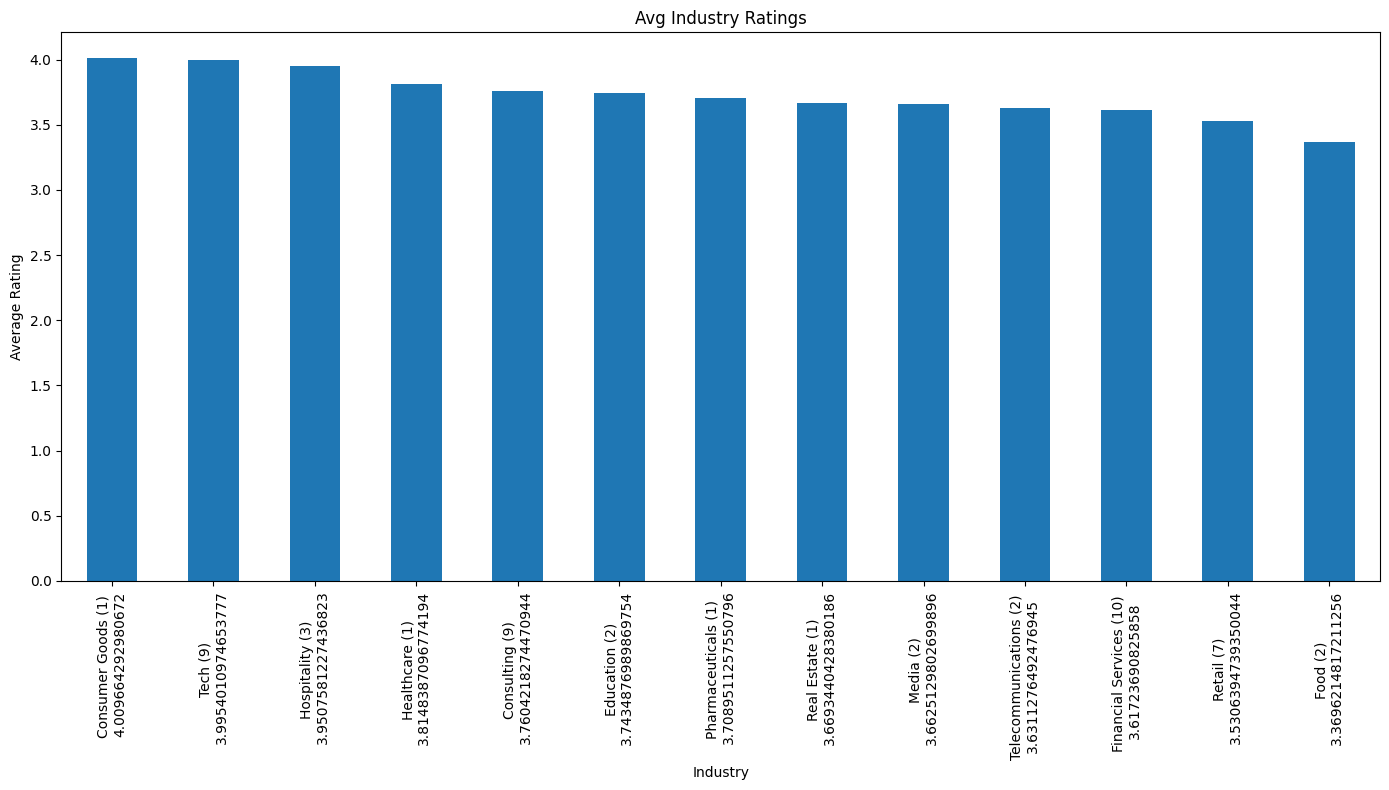

In [351]:
### a few industries that are only made up by one company, let's put that in our chart to avoid jumping to conclusions
### Top industry by ratings

industry_stats = df.groupby('industry').agg({
    'overall_rating': 'mean',
    'firm': 'nunique'
}).reset_index()

industry_stats.columns = ['industry', 'average_rating', 'num_firms']

# Add the number of firms to the industry name
industry_stats['industry_with_count'] = industry_stats.apply(
    lambda row: f"{row['industry']} ({row['num_firms']}) \n{row['average_rating']}", axis=1
)

industry_stats = industry_stats.sort_values(by='average_rating', ascending=False)

fig, axs = plt.subplots(figsize=(14, 8))

industry_stats.plot(kind='bar', x='industry_with_count', y='average_rating', ax=axs, legend=False)
axs.set_xlabel('Industry')
axs.set_ylabel('Average Rating')
axs.set_title('Avg Industry Ratings')

plt.tight_layout()
plt.show()

Things to note:
- We ignore all the companies with counts of (1), "mention in final report due to lack of representation"
- Tech, Hospitality, Consulting, Financial Services, Retail, and Food is worth looking at
1) Tech 
2) Hospitality
3) Consulting and Financial Services
4) Retail and Food (with 2 counts yet average is the lowest)

#### 3.3.1.2 Job titles <a id="3_3_1_2"></a>
- One thing to consider about positions is the seniority of the their jobs (example: Entry, Mid, Senior, etc)
- We will classify our job titles into categories as well (Entry:1, Mid:2, Senior:3)

In [352]:
df.job_title.value_counts().head(50)

job_title
Manager                            3654
Software Engineer                  3431
Analyst                            3294
Associate                          3215
Vice President                     2831
Consultant                         2439
Senior Consultant                  2074
Director                           1842
Senior Associate                   1760
Senior Software Engineer           1723
Assistant Manager                  1635
Business Analyst                   1614
Senior Manager                     1422
Project Manager                    1405
Customer Assistant                 1364
Account Executive                  1063
Customer Service Representative    1030
Assistant Vice President           1026
Crew Member                        1020
Software Developer                  977
Senior Analyst                      892
Account Manager                     892
Financial Analyst                   837
Associate Consultant                802
Cashier                       

In [353]:
df.job_title.value_counts().tail(40)

job_title
Global Head of PMO                                    1
Vice President, Director                              1
Senior Reporting Professional                         1
Regulatory Change Analyst                             1
Financial Support Advisor                             1
Senior Software Engineer(Testing)                     1
Senior Process Development Manager                    1
Global Head of Screening                              1
Manager Wholesale and Market Risk                     1
HDPI Credit Services Executive                        1
Head of Credit Control                                1
SME Analyst                                           1
Business Manager IT                                   1
Global Support Executive (GSE)                        1
Senior Member                                         1
Documentation Analyst                                 1
Manager Business Consulting                           1
I DE Assistant Tech Specialist        

We'll categorize the most common keywords for our jobs and create a new classification for these positions.

In [354]:
keywords_senior = [ 'senior', 'president', 'executive', 'head', 'director', 'chief', 'officer', 'partner', 'vp']
keywords_mid = ['lead', 'manager', 'consultant', 'specialist', 'supervisor', 'administrator', 'coordinator', 'planner', 'advisor']
keywords_entry = ['intern', 'entry', 'associate', 'cashier', 'assistant', 'crew', 'trainee', 'junior', 'representative', 'clerk', 'operator']

def categorize_job(title):

    title_lower = str(title).lower()
    if any(keyword in title_lower for keyword in keywords_senior):
        return 3  # Senior level
    elif any(keyword in title_lower for keyword in keywords_entry):
        return 1  # Entry level
    elif any(keyword in title_lower for keyword in keywords_mid):
        return 2  # Mid level
    else:
        return 2  # defaults to mid level for vague terms

In [355]:
df['level'] = df['job_title'].apply(categorize_job)

# Insert the 'level' column before the 'job_title' column
job_title_index = df.columns.get_loc('job_title')
df.insert(job_title_index, 'level', df.pop('level'))

df.head(3)

industry firm  level                   job_title            status years  \
0     Tech  IBM      2                   Test Lead   Former Employee     1   
1     Tech  IBM      1  Associate Systems Engineer   Former Employee   0.5   
2     Tech  IBM      3            Program Director  Current Employee   0.5   

      location  overall_rating  work_life_balance  culture_values  career_opp  \
0  Halifax, NS               1                1.0             1.0         4.0   
1    Bangalore               3                4.0             3.0         3.0   
2    Tampa, FL               2                1.0             1.0         1.0   

   comp_benefits  senior_mgmt  \
0            2.0          1.0   
1            1.0          2.0   
2            2.0          1.0   

                                            headline  \
0                             Very bad place to work   
1                          Associate System Engineer   
2  IBM - the people are great - Company could car...   

                                                pros  \
0          IBM provides lot of training to employees   
1  Good Work Life Balance, Cool Projects.Employee...   
2  Amazing, talented, people. Everything that is ...   

                                                cons  \
0  Salary, They treat employees very bad. Employe...   
1  NO HIKE. AN IBM EMPLOYEE DOESN'T  HAVE RIGHT T...   
2  IBM the corporation does not value their emplo...   

                                      processed_text  
0  bad place work IBM provide lot training employ...  
1  associate System Engineer Good Work Life Balan...  
2  IBM people great company care amazing talented...

In [356]:
### Let's check our levels:
condition = (df['industry'] == 'Tech') & (df['level'] == 3)
filtered_df = df.loc[condition, ['industry', 'level', 'job_title']]
filtered_df

industry  level                   job_title
2          Tech      3            Program Director
4          Tech      3    Senior Software Engineer
8          Tech      3           Senior Consultant
11         Tech      3  Senior Java Developer/Lead
12         Tech      3           Senior Consultant
...         ...    ...                         ...
124480     Tech      3             Senior Engineer
124483     Tech      3    Senior Marketing Manager
124486     Tech      3    Senior Software Engineer
124489     Tech      3            Director Support
124491     Tech      3     Senior Research Analyst

[9544 rows x 3 columns]

In [357]:
# Let's check the average rating of each firm within their different job levels

df_level = df.groupby(['industry', 'level'])['overall_rating'].mean().unstack()
df_level['total_avg_rating'] = df_level.sum(axis=1)
df_level

level                      1         2         3  total_avg_rating
industry                                                          
Consulting          3.827266  3.734968  3.754766         11.317001
Consumer Goods      4.038929  3.965077  4.115486         12.119492
Education           4.050336  3.693031  3.488889         11.232255
Financial Services  3.684516  3.619800  3.581466         10.885782
Food                3.303560  3.430204  3.763441         10.497205
Healthcare          3.960317  3.785527  3.794702         11.540547
Hospitality         3.877551  3.904569  4.211986         11.994105
Media               3.751118  3.648089  3.658701         11.057907
Pharmaceuticals     3.623188  3.768224  3.625263         11.016676
Real Estate         3.787879  3.584934  3.803390         11.176202
Retail              3.593828  3.443021  3.707143         10.743992
Tech                4.000000  3.990069  4.008382         11.998451
Telecommunications  3.659151  3.624180  3.638481         10.921813

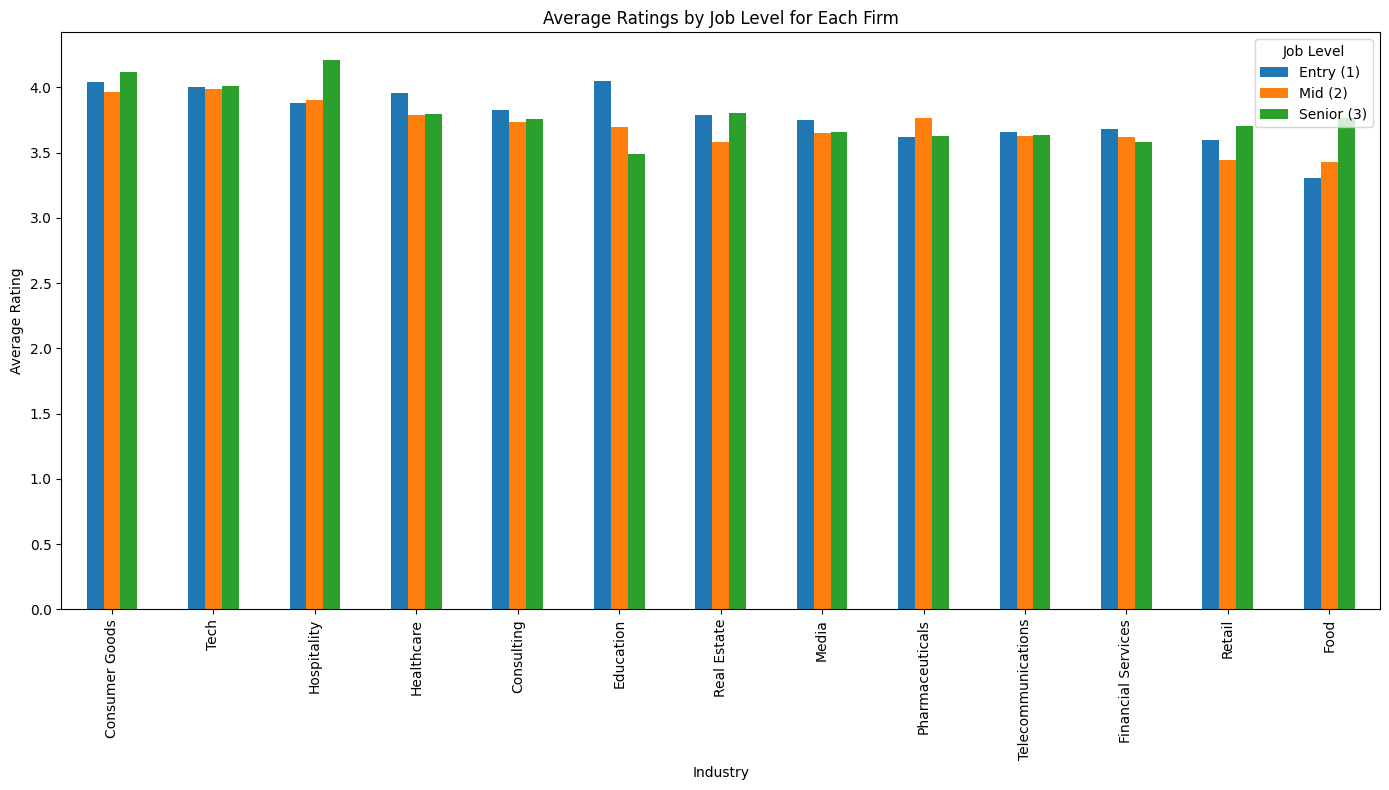

In [358]:
df_level = df_level.sort_values(by='total_avg_rating', ascending=False)
df_level = df_level.drop(columns=['total_avg_rating'])

fig, axs = plt.subplots(figsize=(14, 8))

df_level.plot(kind='bar', ax=axs)

axs.set_xlabel('Industry')
axs.set_ylabel('Average Rating')
axs.set_title('Average Ratings by Job Level for Each Firm')
axs.legend(title='Job Level', labels=['Entry (1)', 'Mid (2)', 'Senior (3)'])

plt.tight_layout()
plt.show()


### There may not be an interaction, outcome of result is effected 
### Does job level effect overall rating? Is it vary in industries, then yes.

Observations:
- My prediction was the higher seniority, the higher the satisfaction. This seems to not be the case in many industries!
- Tech has higher in every job level than financial services and consulting (we have the most samples for these). 
    - Seniority within a company dosen't necessarily contribute to higher satisfaction, its seems to be all throughout
- Retail and Food has much lower level 1 ratings than level 3 ratings (This makes sense)

#### 3.3.1.3 Location<a id ='3_3_1_3'></a>
- Now let's check location ratings, the last time we check the 


In [231]:
df['location'].nunique()

275

In [232]:
#We still have 275 location, so let's pick the top 100 most reviewed locations and take a look at those
top100 = df['location'].value_counts().head(100).index
df_top100 = df[df['location'].isin(top100)]

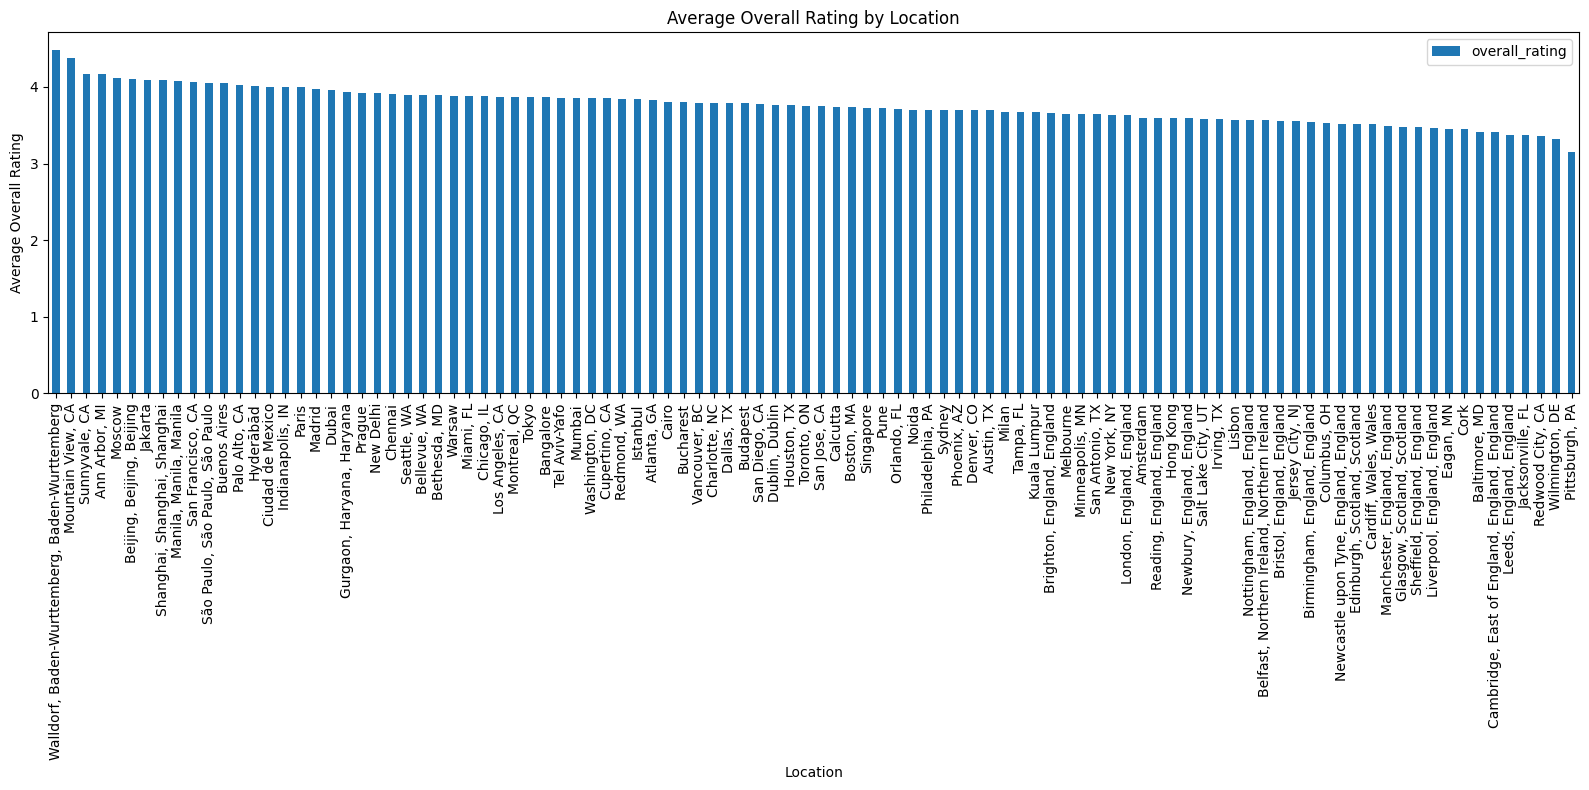

In [233]:
df_location = df_top100.groupby(by='location').agg({'overall_rating':'mean'}).reset_index()
df_location.sort_values(by='overall_rating', inplace= True, ascending=False)

fig, axs = plt.subplots(figsize = (16,8))

df_location.plot(kind='bar', x='location', y='overall_rating', ax = axs)
axs.set_xlabel('Location')
axs.set_ylabel('Average Overall Rating')
axs.set_title('Average Overall Rating by Location')

plt.tight_layout()
plt.show()

Seems to not be country oriented, what about some cities makes it better to work at than others? We'll take a deeper look later

### 3.3.2 User ratings <a id = '3_3_2'></a>

Let's take a look at the correlation of the 5 ratings to the overall rating

#### 3.3.2.1 Correlation Matrix and Analysis <a id="3_3_2_1"></a>

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150220 entries, 0 to 150219
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   industry           150220 non-null  object 
 1   firm               150220 non-null  object 
 2   level              150220 non-null  int64  
 3   job_title          150186 non-null  object 
 4   status             82281 non-null   object 
 5   years              57757 non-null   object 
 6   location           150220 non-null  object 
 7   overall_rating     150220 non-null  int64  
 8   work_life_balance  150220 non-null  float64
 9   culture_values     150220 non-null  float64
 10  career_opp         150220 non-null  float64
 11  comp_benefits      150220 non-null  float64
 12  senior_mgmt        150220 non-null  float64
 13  headline           150220 non-null  object 
 14  pros               150220 non-null  object 
 15  cons               150220 non-null  object 
 16  pr

In [237]:
### We want to see the correlation among all of these values
rate_cols = ['overall_rating', 'work_life_balance', 'culture_values', 'career_opp','comp_benefits', 'senior_mgmt','status','years','level']

#Let's also encode the categories now so we can check the correlation:
# '>10' becomes '10'
df['years'] = df['years'].replace('>10', '10')

# 'status' so that 'Former Employee' is 0 and 'Current Employee' is 1
df['status'] = df['status'].apply(str)
df['status'] = df['status'].str.strip()
df['status'] = df['status'].replace({'Former Employee': 0, 'Current Employee': 1})

df_rate = df[rate_cols] ###Temporarily drop null values, let's see if they are correlated at all
df_rate = df_rate.dropna(axis=0)

                   overall_rating  work_life_balance  culture_values  \
overall_rating           1.000000           0.540281        0.762509   
work_life_balance        0.540281           1.000000        0.530497   
culture_values           0.762509           0.530497        1.000000   
career_opp               0.712306           0.377443        0.625169   
comp_benefits            0.594337           0.381945        0.505777   
senior_mgmt              0.745042           0.517085        0.732909   
status                  -0.017058          -0.003065       -0.010450   
years                   -0.022045          -0.007919       -0.018357   
level                   -0.014855          -0.005258       -0.019087   

                   career_opp  comp_benefits  senior_mgmt    status     years  \
overall_rating       0.712306       0.594337     0.745042 -0.017058 -0.022045   
work_life_balance    0.377443       0.381945     0.517085 -0.003065 -0.007919   
culture_values       0.625169       

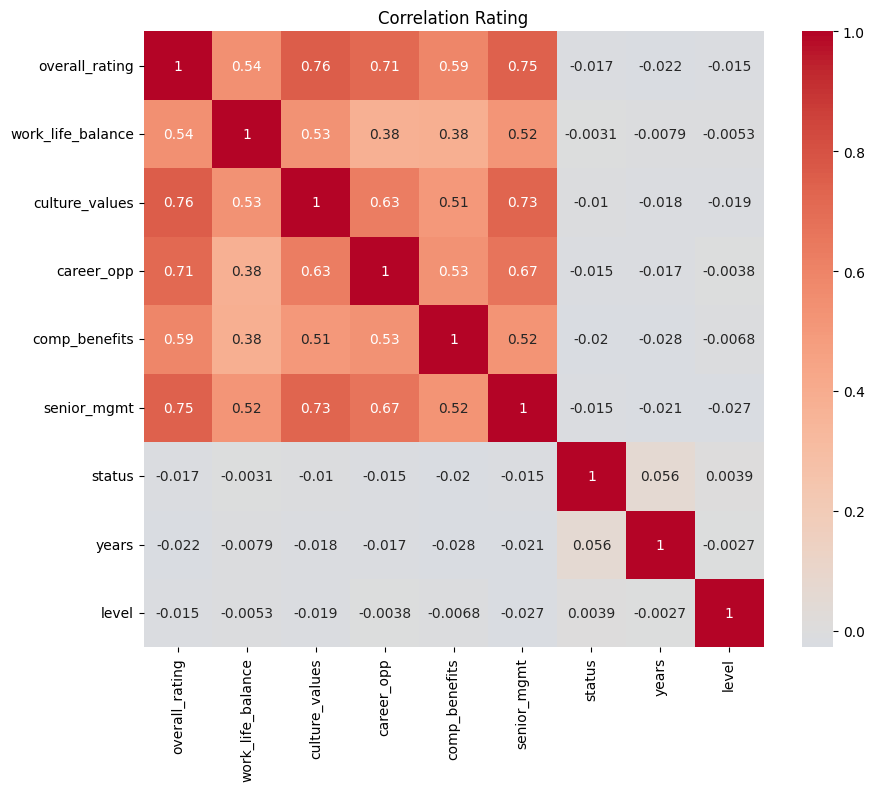

In [241]:
correlation_matrix = df_rate.corr(method='pearson') # Pearson, Spearman, and Kendall correlation

print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Rating')
plt.show()

# tree based model, permutation 
# shaft, importance of each variabe
# linear, coefficients and p-values

This is interesting, the correlation for current/former, years they've worked, and level of employment is not significant
- I thought that the level of management one is in the industry leads to perhaps higher satisfaction
- The other metrics 5 seems to have much higher correlation, especially culture and senior management.

#### 3.3.2.2 Permutation testing <a id="3_3_2_2"></a>
- We will also conduct a permutation test to further test our variable correlation relationship

In [279]:
def permutation_test_corr(x, y, num_permutations=10000):
    
    # Calculate the observed correlation
    observed_corr = np.corrcoef(x, y)[0, 1]
    # array to store permuted correlations
    permuted_corrs = np.zeros(num_permutations)
    
    for i in range(num_permutations):
        # Shuffle y and calculate the correlation with x
        shuffled_y = np.random.permutation(y)
        permuted_corrs[i] = np.corrcoef(x, shuffled_y)[0, 1]
    
    # Calculate the p-value
    p_value = np.sum(np.abs(permuted_corrs) >= np.abs(observed_corr)) / num_permutations
    
    return observed_corr, p_value

In [280]:
rate_cols = ['work_life_balance', 'culture_values', 'career_opp','comp_benefits', 'senior_mgmt']

for rate_col in rate_cols:
    observed_corr, p_value = permutation_test_corr(df['overall_rating'], df[rate_col])
    print(f"{rate_col} Observed Correlation: {observed_corr}")
    print(f"P-value: {p_value}")

work_life_balance Observed Correlation: 0.5423108152561547
P-value: 0.0
culture_values Observed Correlation: 0.7562670345715382
P-value: 0.0
career_opp Observed Correlation: 0.7060455664580618
P-value: 0.0
comp_benefits Observed Correlation: 0.6013150150986729
P-value: 0.0
senior_mgmt Observed Correlation: 0.7413496454180527
P-value: 0.0


These factors have the most correlation
1) Culture values
2) Senior Management
3) Career Opportunities

Followed by:
4) Comp_benefits and Work life balance

### 3.3.3 Employee Reviews Analysis
We investigate our reviews to see any common trends and keywords employees look for when considering job satisfaction

#### 3.3.3.1 Basic Text Stat <a id = "3_3_3_1"></a>
- Let's look at common word stats first, like word and char count in relation to ratings

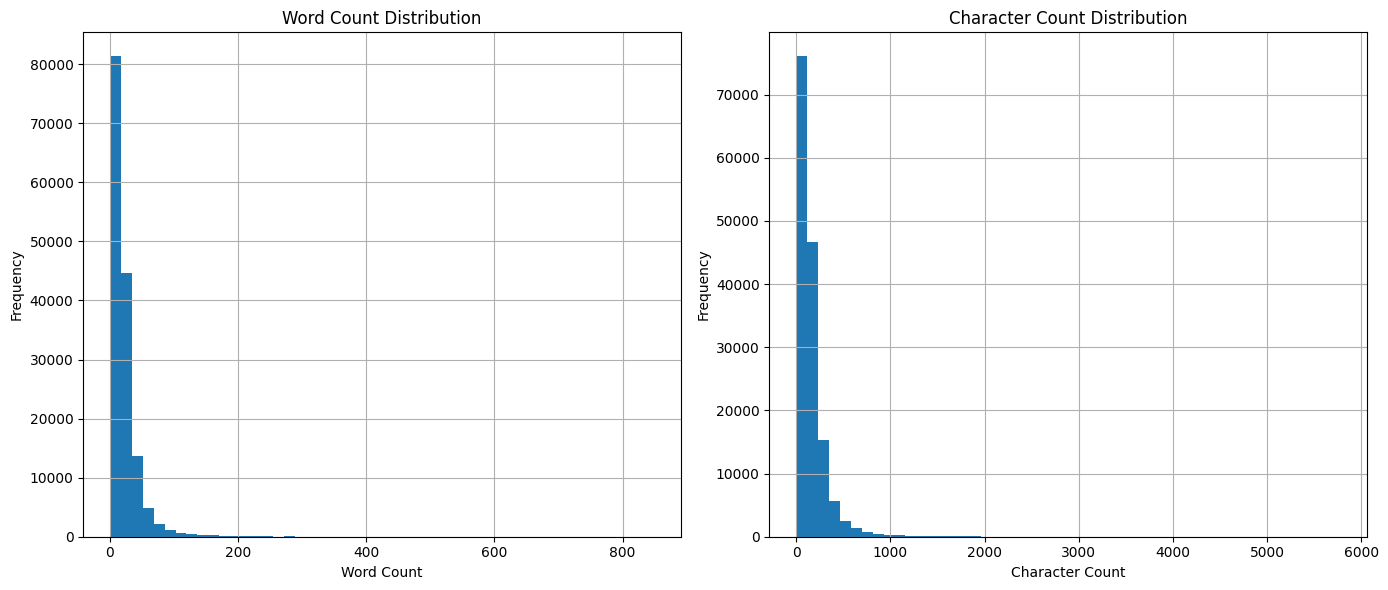

In [338]:
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['processed_text'].apply(lambda x: len(x))

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['word_count'].hist(bins=50)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['char_count'].hist(bins=50)
plt.title('Character Count Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<Axes: xlabel='char_count', ylabel='overall_rating'>

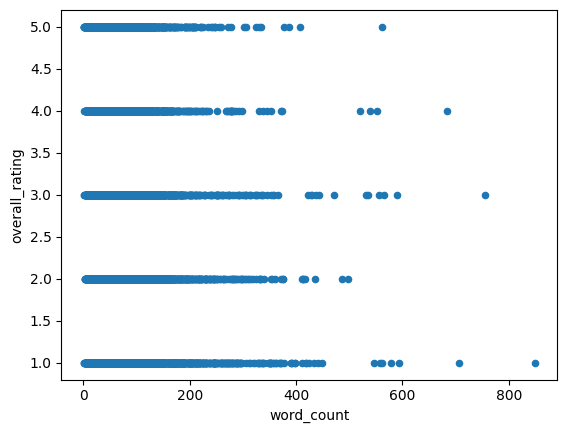

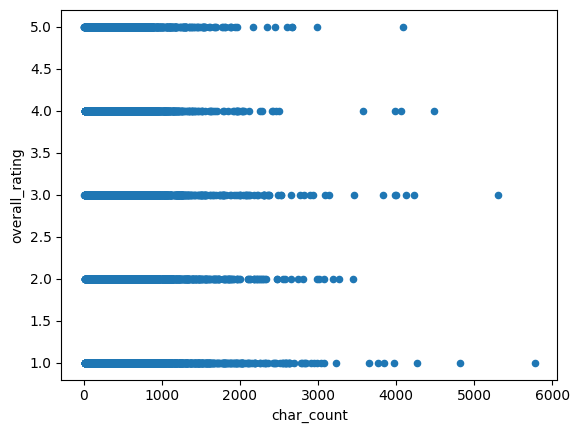

In [339]:
# Does the length of the review cause higher/lower ratings?
df.plot(kind='scatter', x='word_count',y ='overall_rating')
df.plot(kind='scatter', x='char_count',y ='overall_rating')

Seems rather consistent all across with a few outliers, dosen't seem like there is a correlation

#### 3.3.3.2 Common Words and Phrases <a id = "3_3_3_2"></a>

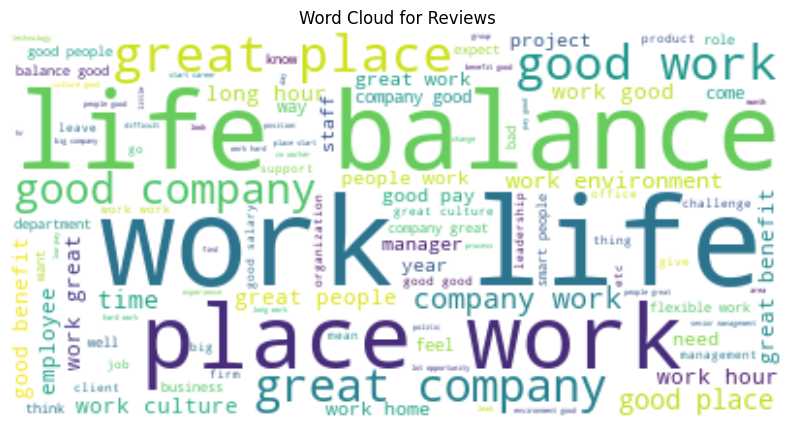

In [260]:
wordcloud = WordCloud(background_color='white', max_words=100).generate(' '.join(df['processed_text']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Reviews')
plt.axis('off')
plt.show()

- We see all the buzzwords associated with work life culture but this dosen't show us much yet
- Let's use n-grams to see if we can find more usefull 'phrases' commonly used

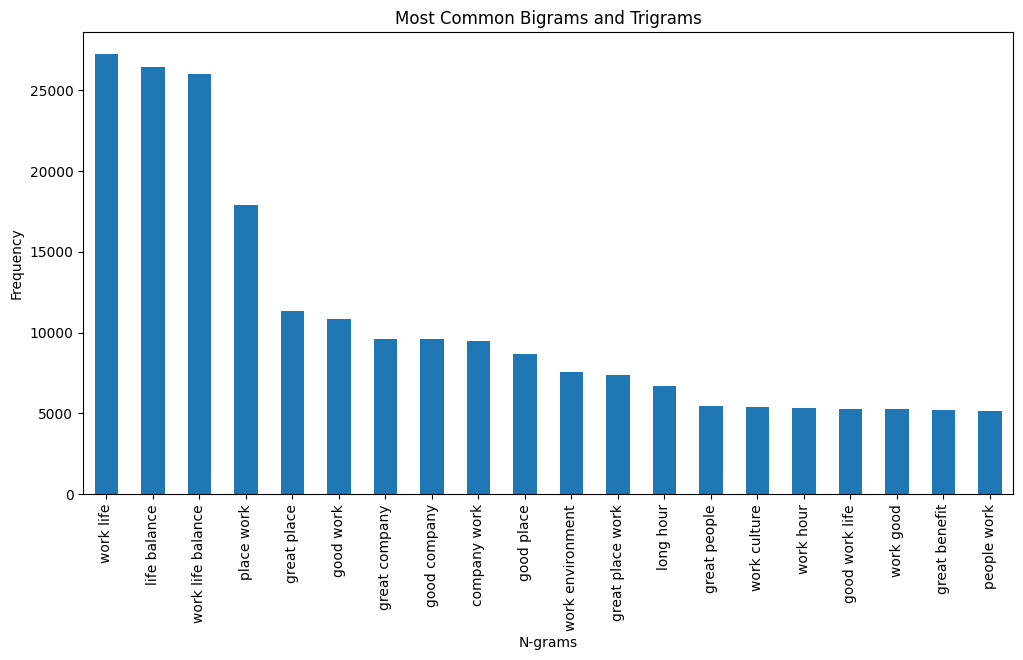

In [264]:
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20)
X_ngrams = vectorizer.fit_transform(df['processed_text'])

ngrams_df = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer.get_feature_names_out())  #easier to handle with as pandas df

# Plot most common n-grams
ngrams_df.sum().sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Most Common Bigrams and Trigrams')
plt.xlabel('N-grams')
plt.ylabel('Frequency')
plt.show()

'work life' and 'life balance' seems to pop up repeatedly even in the reviews

#### 3.3.3.3 Topic Modeling (LDA) <a id = "3_3_3_3"></a>

In [337]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(df['processed_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tf)

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

display_topics(lda, tf_vectorizer.get_feature_names_out(), 10)

Topic 0:
work good life balance place salary great company culture project
Topic 1:
great work company good people culture opportunity place career lot
Topic 2:
great benefit management employee pay company work high training opportunity
Topic 3:
work good hour great pay job time long people environment
Topic 4:
people work management company manager team year like employee time


Common topics including good life, company, benefits, good hour, management, etc

#### 3.3.3.4 Keyword Analysis: High/Low ratings and Pro/Cons
- We also want to see if there are particular keywords in reference to higher and lower ratings of their jobs
- We start by analying pro and con columns, and perform sentiment analysis to see what is associated with higher/lower sentiments

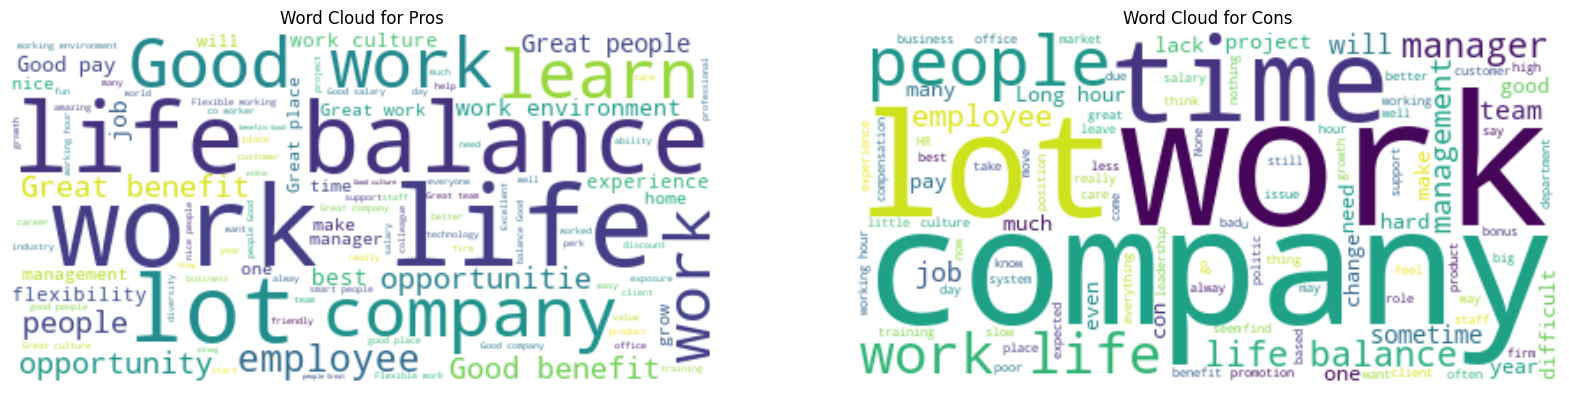

In [259]:
# word clouds for pros and cons
pros_text = ' '.join(df['pros'].fillna('').tolist())
cons_text = ' '.join(df['cons'].fillna('').tolist())

wordcloud_pros = WordCloud(background_color='white', max_words=100).generate(pros_text)
wordcloud_cons = WordCloud(background_color='white', max_words=100).generate(cons_text)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pros, interpolation='bilinear')
plt.title('Word Cloud for Pros')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cons, interpolation='bilinear')
plt.title('Word Cloud for Cons')
plt.axis('off')

plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


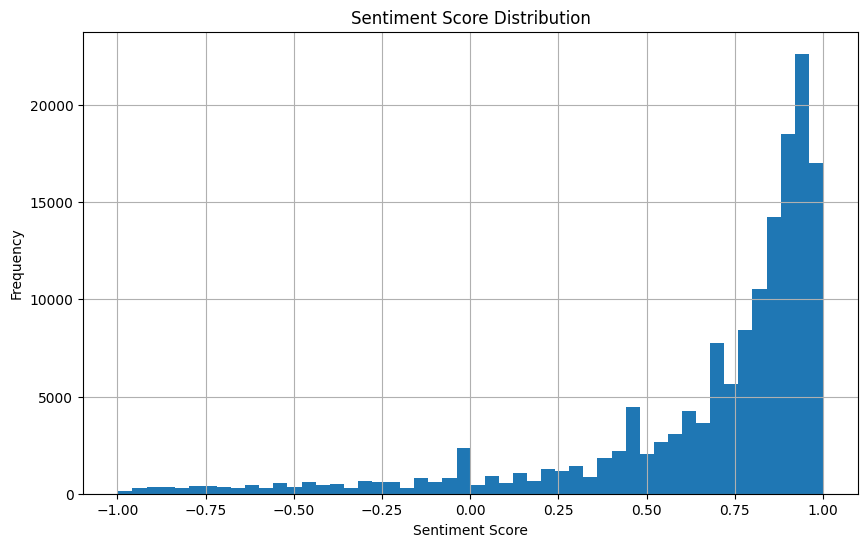

In [342]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

df['sentiment_score'] = df['processed_text'].apply(get_sentiment_score)

plt.figure(figsize=(10, 6))
df['sentiment_score'].hist(bins=50)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [344]:
### Let's check if the sentiment score captures the overall_rating accurately
correlation = df['overall_rating'].corr(df['sentiment_score'])
print(correlation)


# won't be able to tell that based off the correlation
# strong correlation is .5, this is a weak correlation. The words in text don't strong correlate with employee rating itself
# value
# understand nltk sentiment intuition

0.3659005619936703


It seems like there is a moderate correlation with the sentiment analysis and the overall_rating, we will use our sentiment analysis as gauge of bad/good rating

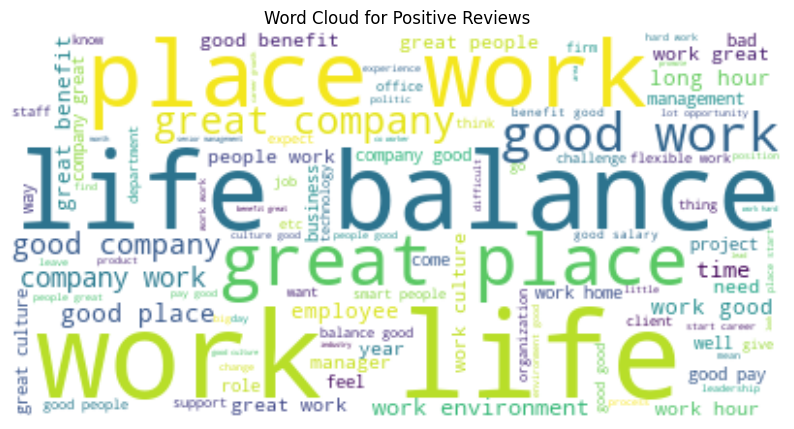

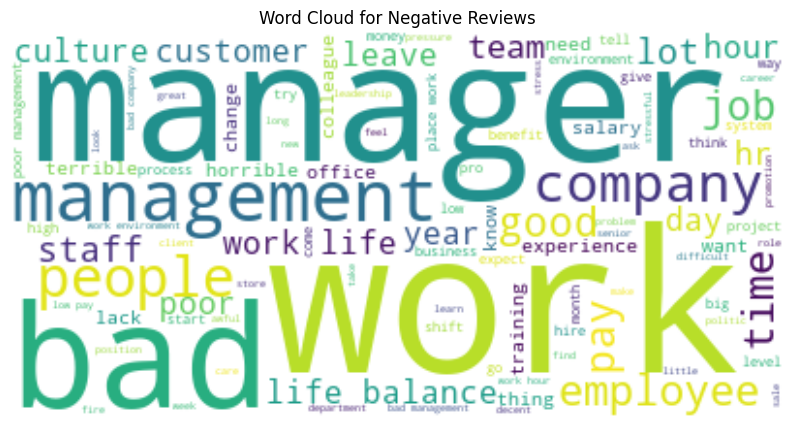

In [270]:
positive_reviews = df[df['sentiment_score'] > 0.5]['processed_text']
negative_reviews = df[df['sentiment_score'] < -0.5]['processed_text']

# word cloud for positive reviews
wordcloud_positive = WordCloud(background_color='white', max_words=100).generate(' '.join(positive_reviews))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# word cloud for negative reviews
wordcloud_negative = WordCloud(background_color='white', max_words=100).generate(' '.join(negative_reviews))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

- positives seem to be good all throughout
- That's a bold 'manager' for negatives, companies really need to do a better job with their managers.

#### 3.3.3.5 Correlation: Words and Overall Ratings

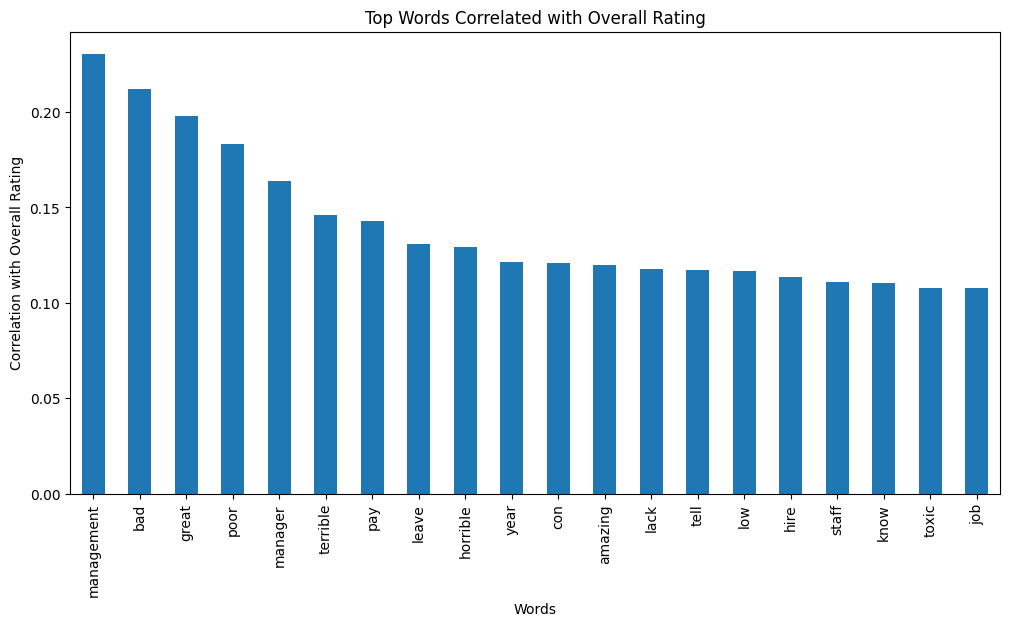

In [276]:
# Compute correlation between word counts and overall ratings
word_vectorizer = CountVectorizer(max_features=1000)
X_words = word_vectorizer.fit_transform(df['processed_text'])
word_features = pd.DataFrame(X_words.toarray(), columns=word_vectorizer.get_feature_names_out())
correlation = word_features.corrwith(df['overall_rating'])

# Plot the top correlated words
top_correlated_words = correlation.abs().sort_values(ascending=False).head(20)      #make sure we take absolute value
top_correlated_words.plot(kind='bar', figsize=(12, 6))
plt.title('Top Words Correlated with Overall Rating')
plt.xlabel('Words')
plt.ylabel('Correlation with Overall Rating')
plt.show()

- Of course good/bad connotation terms like bad, great, amazing, poor, horrible has the highest effect
- And we see again management, manager, and pay has the highest correlation to overall rating. Let's keep this in mind

#### 3.3.3.6 Industry and Level Specific Ratings <a id = '3_3_3_6'></a>
- So far we've done an analysis on everything in general, but different industries and levels of works should also have thier own conceerns.
- Let's test this by doing the same thing through all industries and levels

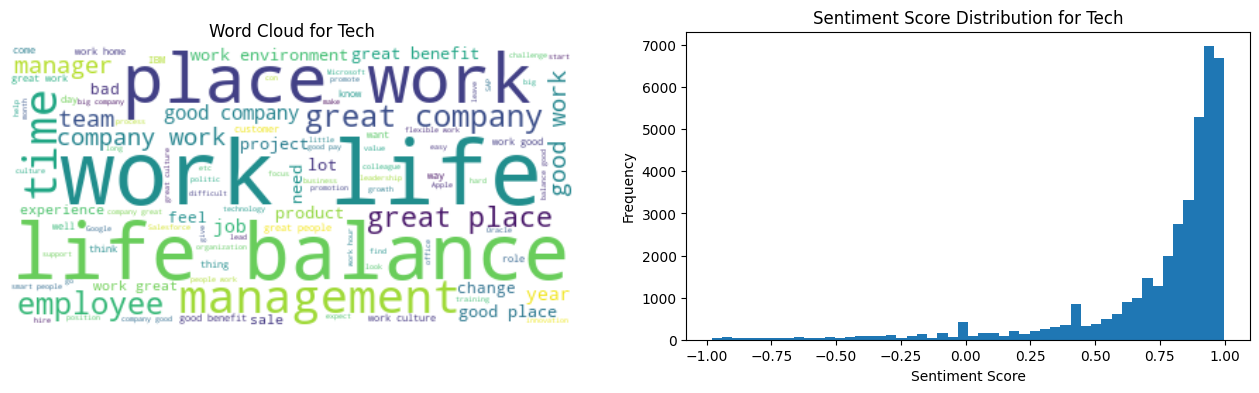

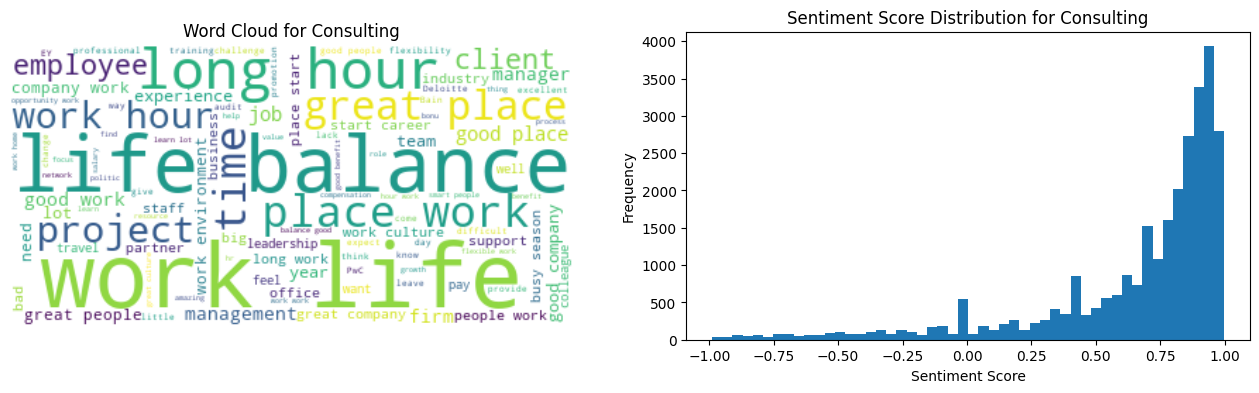

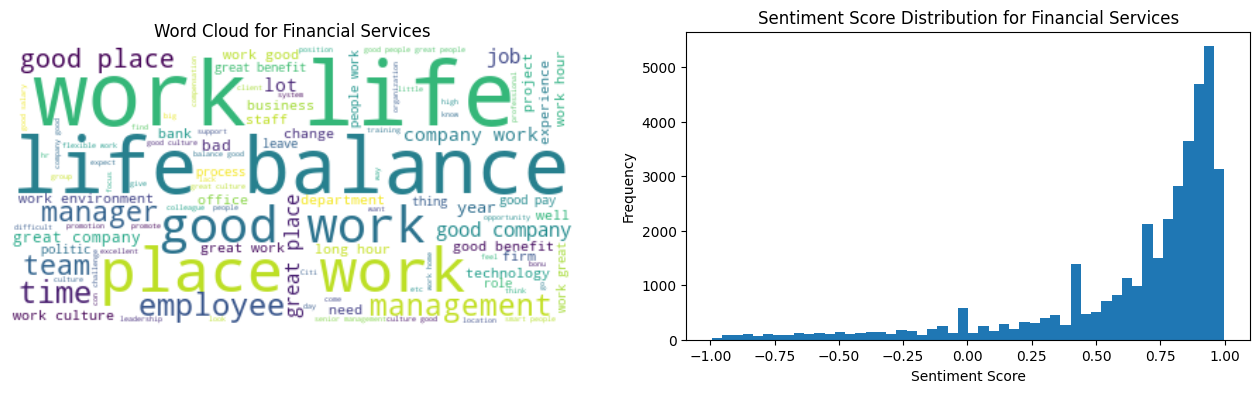

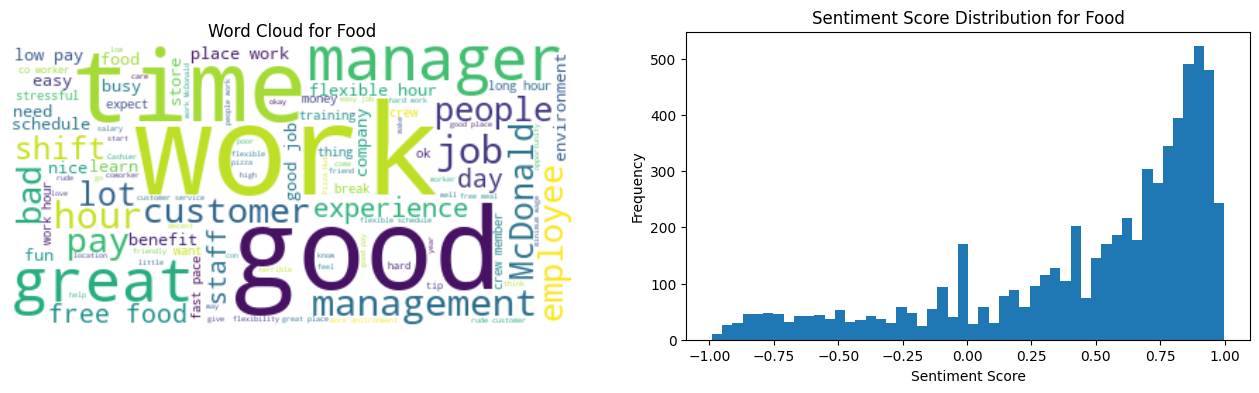

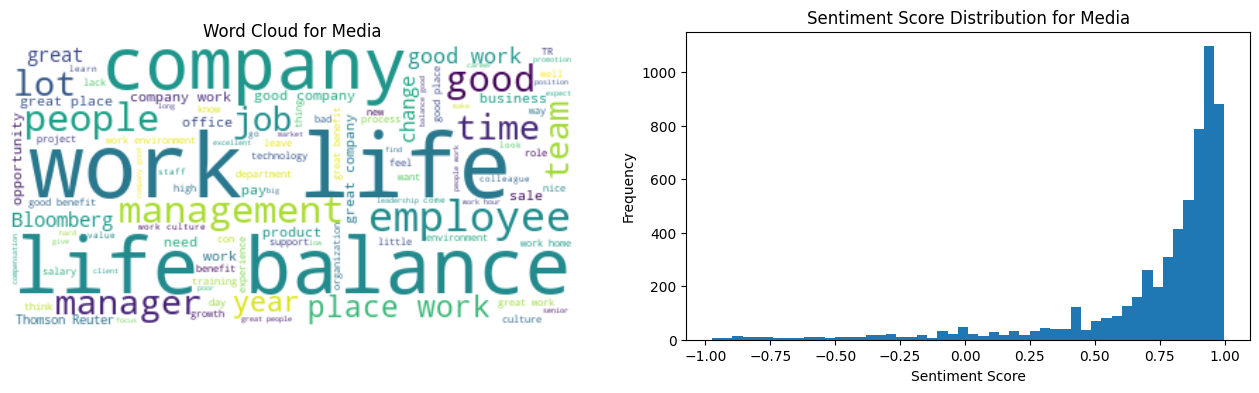

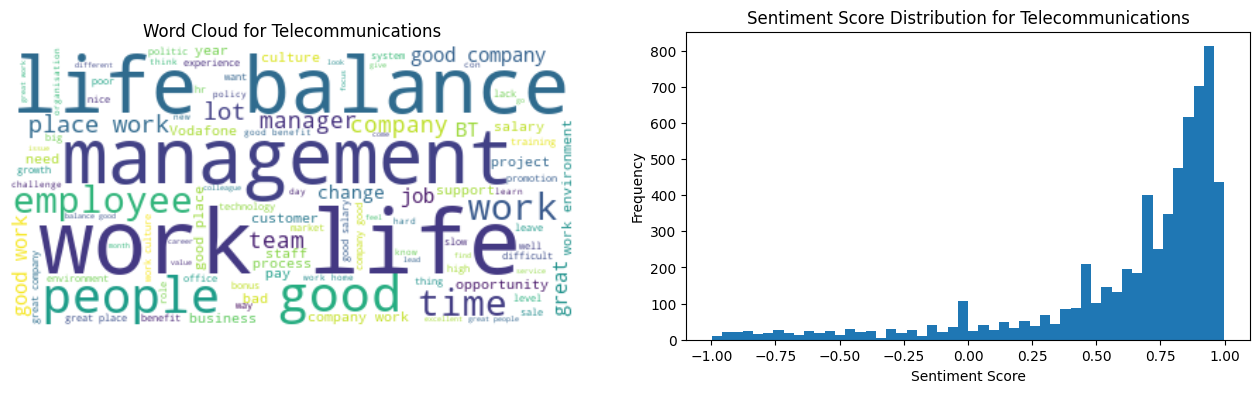

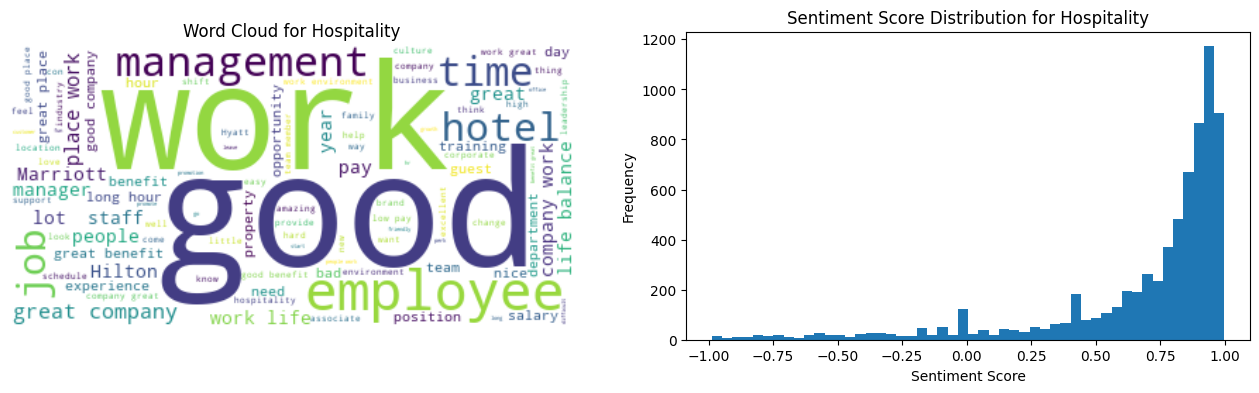

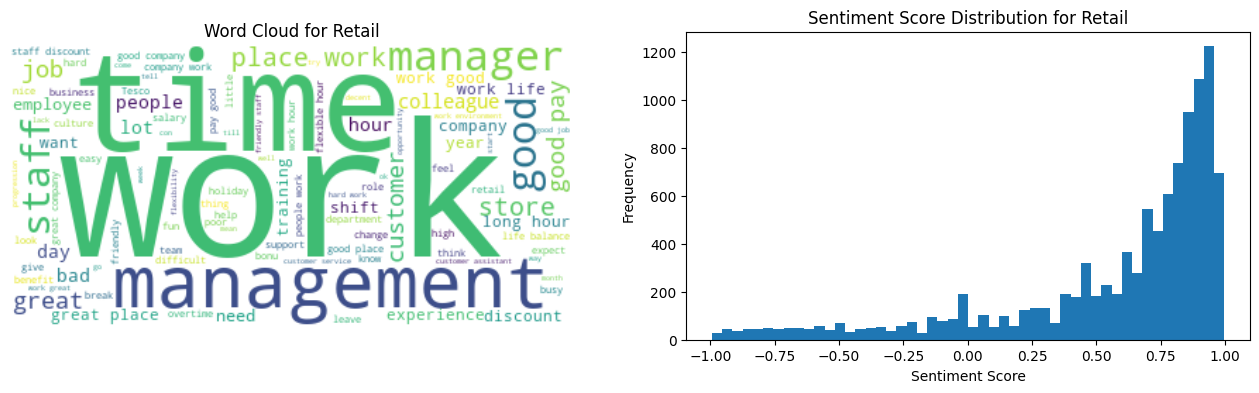

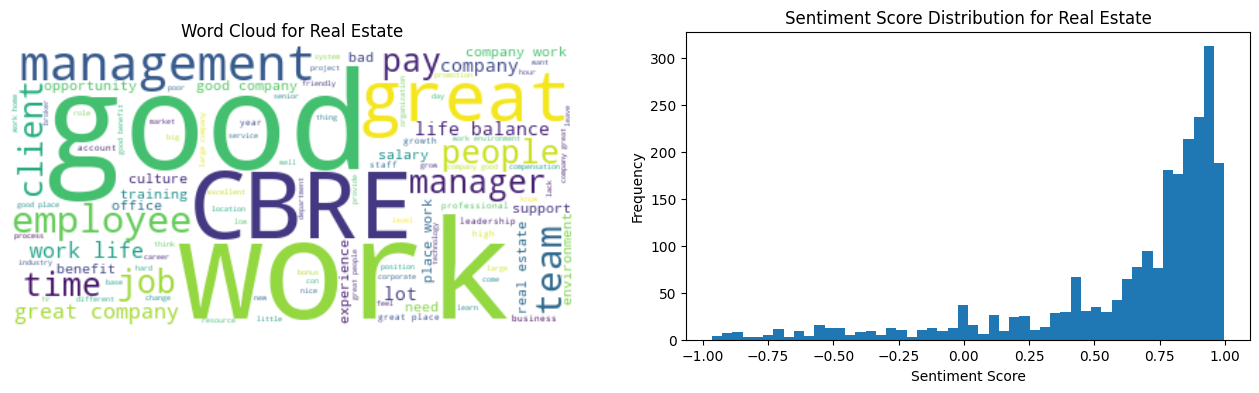

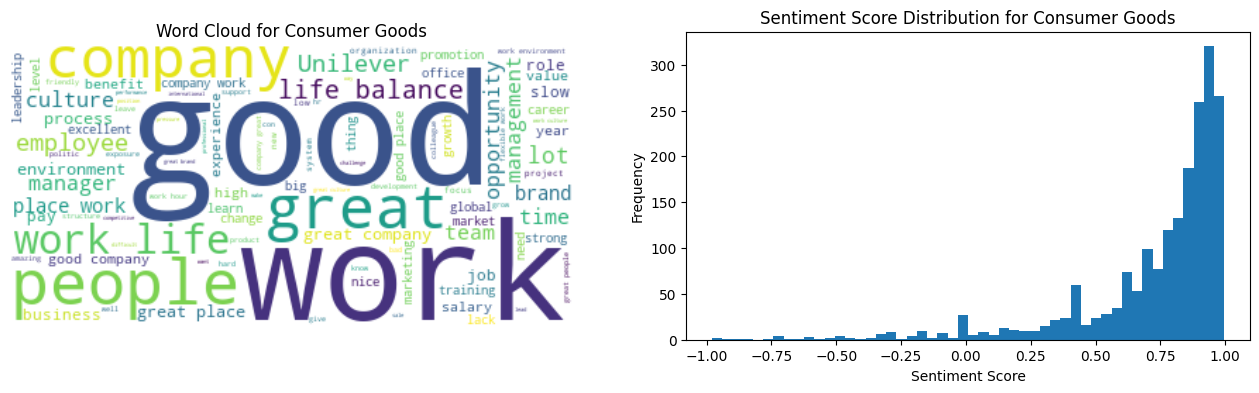

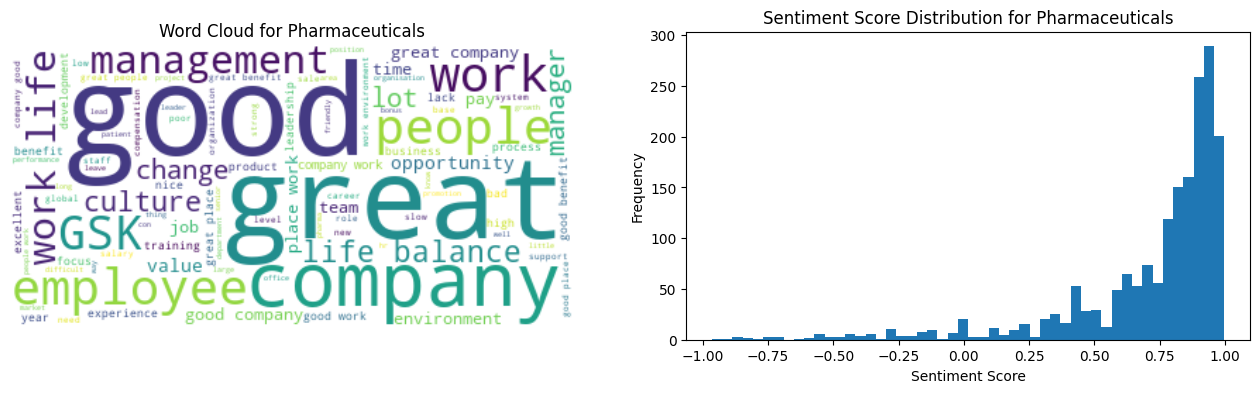

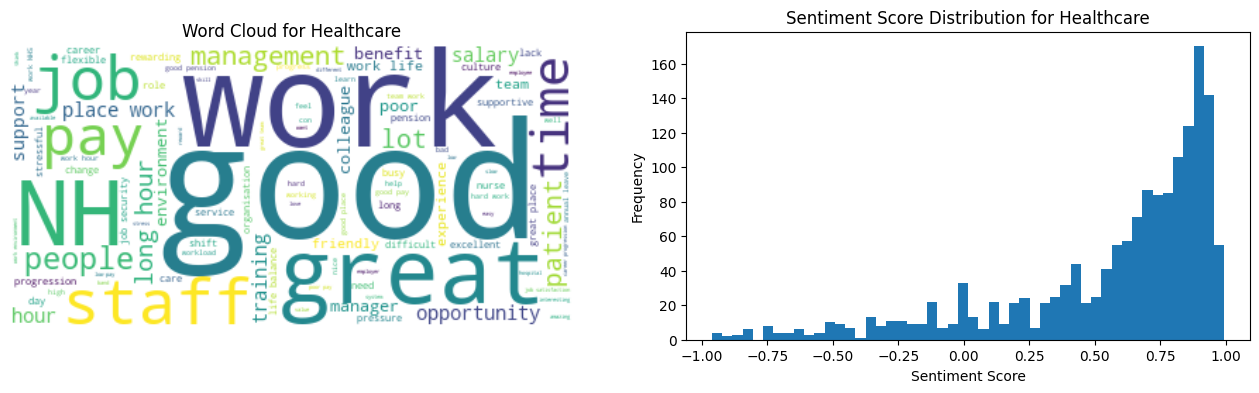

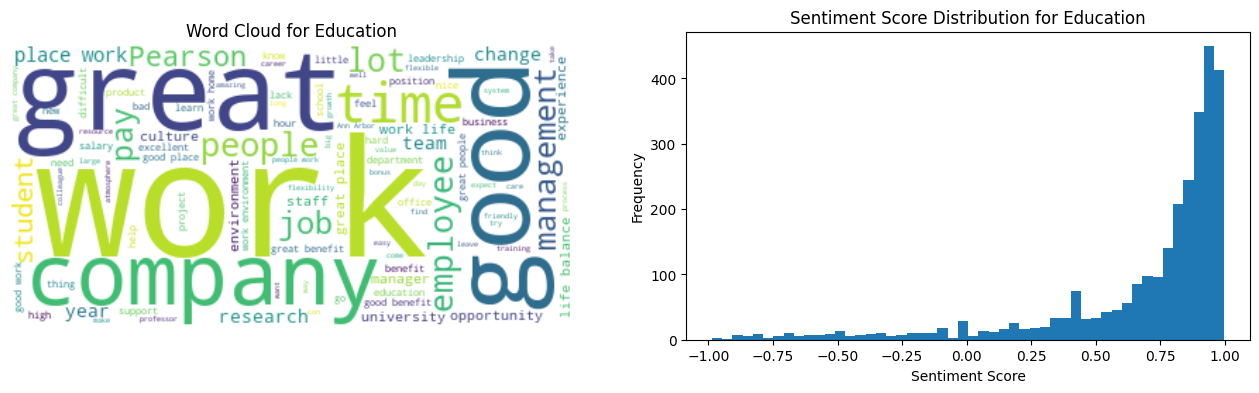

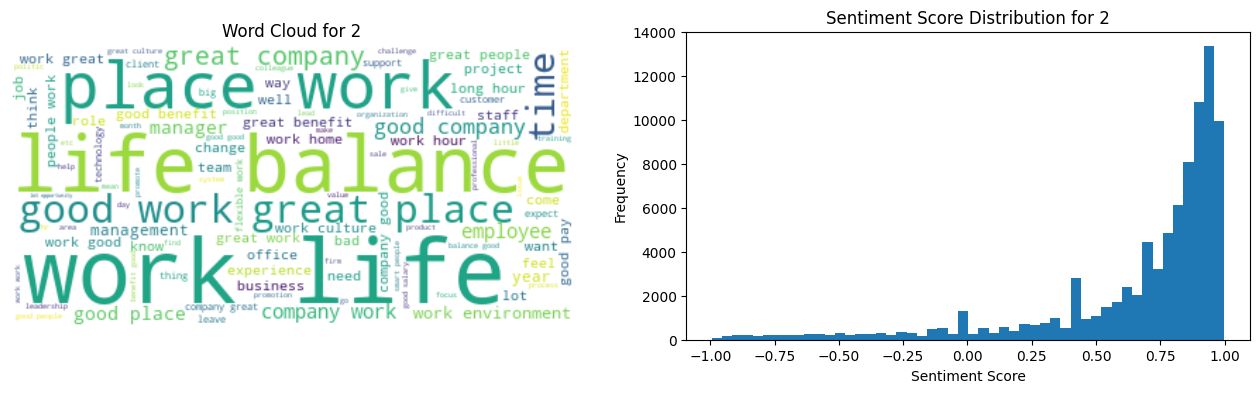

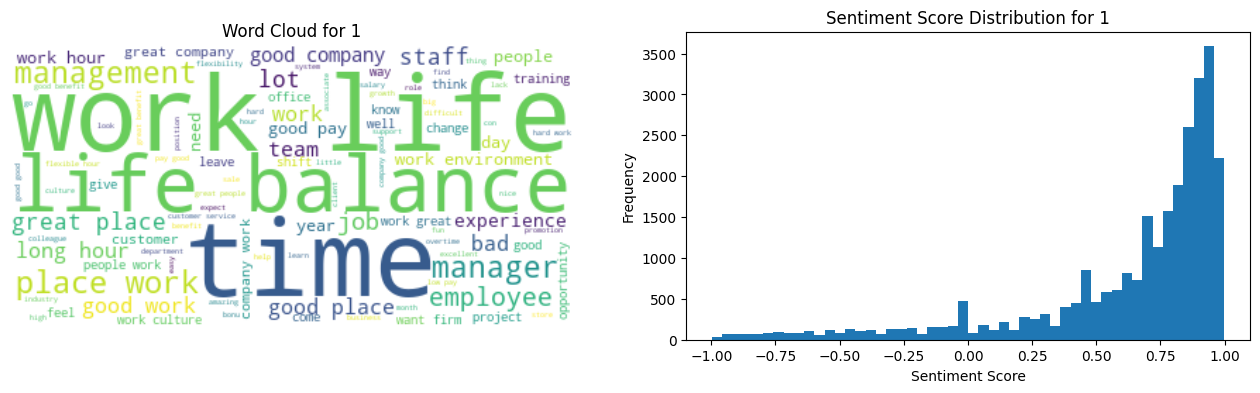

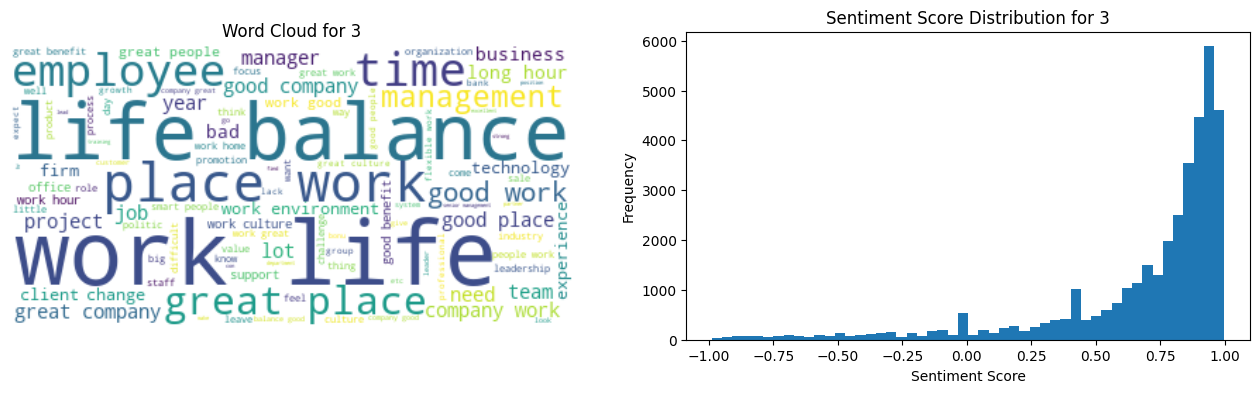

In [287]:
def keyword_analysis_by_category(df, category_col, category_value, text_col, sentiment_score_col):
    subset = df[df[category_col] == category_value]
    text = ' '.join(subset[text_col].fillna(''))

    fig, axs = plt.subplots(1, 2, figsize = (16,4))

    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    axs[0].imshow(wordcloud, interpolation='bilinear')
    axs[0].set_title(f'Word Cloud for {category_value}')
    axs[0].axis('off')

    sentiment_scores = subset[sentiment_score_col]
    axs[1].hist(sentiment_scores, bins=50)
    axs[1].set_title(f'Sentiment Score Distribution for {category_value}')
    axs[1].set_xlabel('Sentiment Score')
    axs[1].set_ylabel('Frequency')

# by industry
industries = df['industry'].unique()
for industry in industries:
    keyword_analysis_by_category(df, 'industry', industry, 'processed_text', 'sentiment_score')

# by management level
levels = df['level'].unique()
for level in levels:
    keyword_analysis_by_category(df, 'level', level, 'processed_text', 'sentiment_score')


Let's compute the correlation of keywords to overall_ratings for each industry and management level

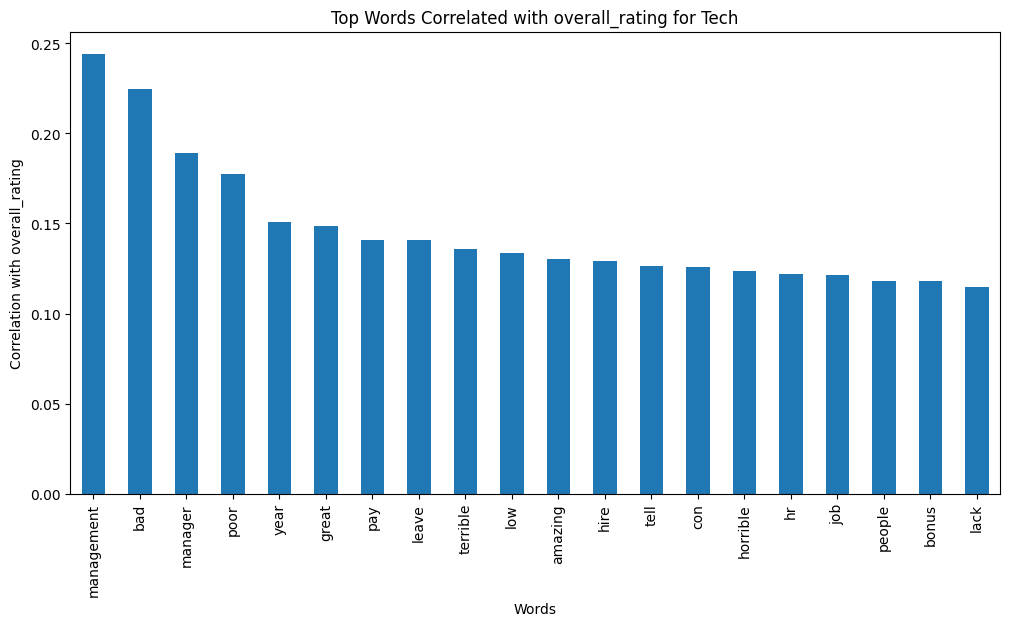

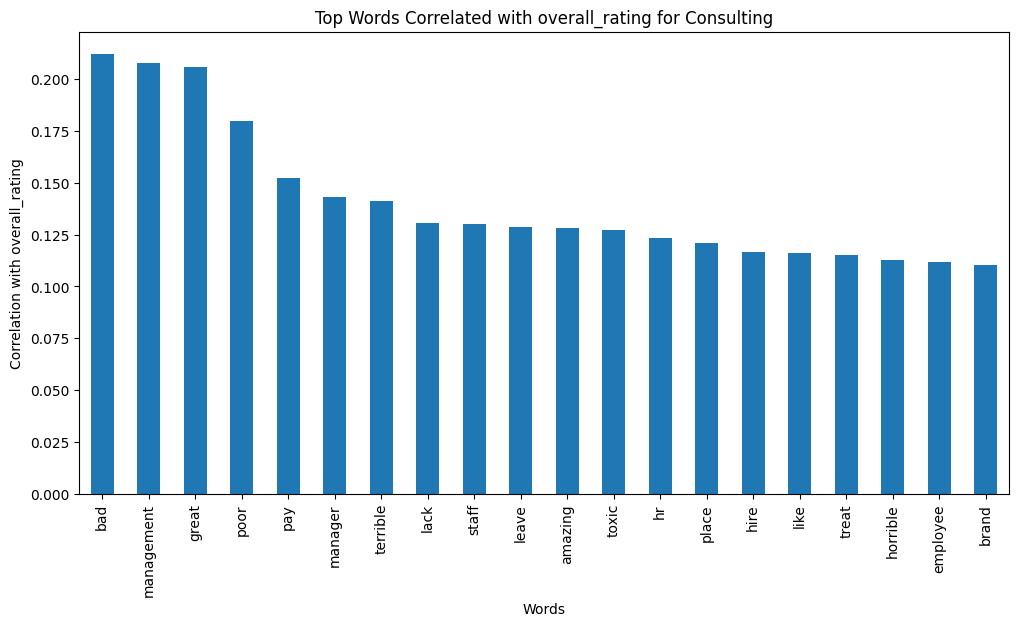

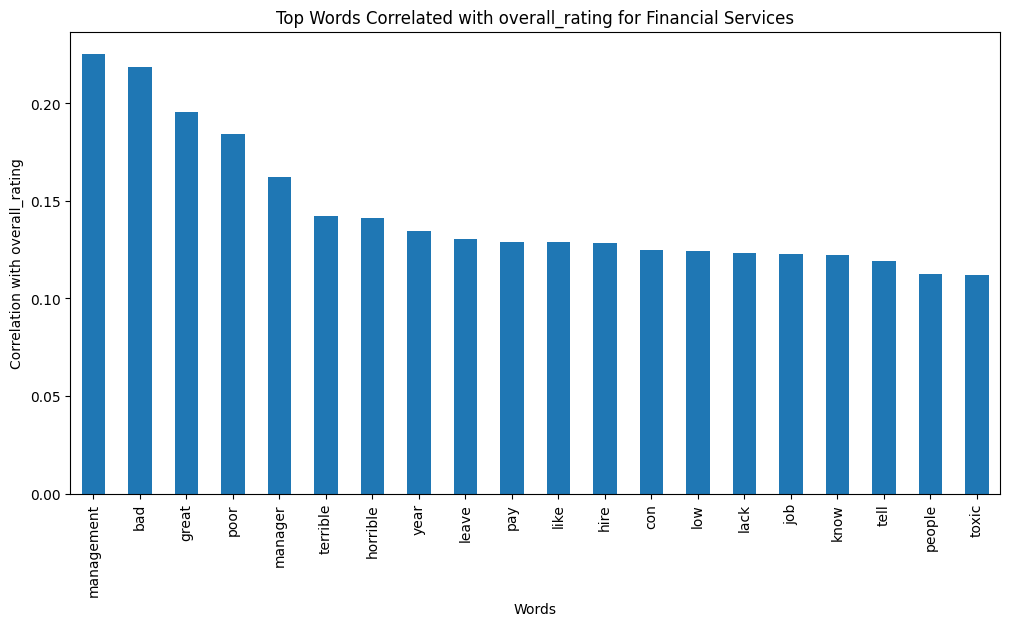

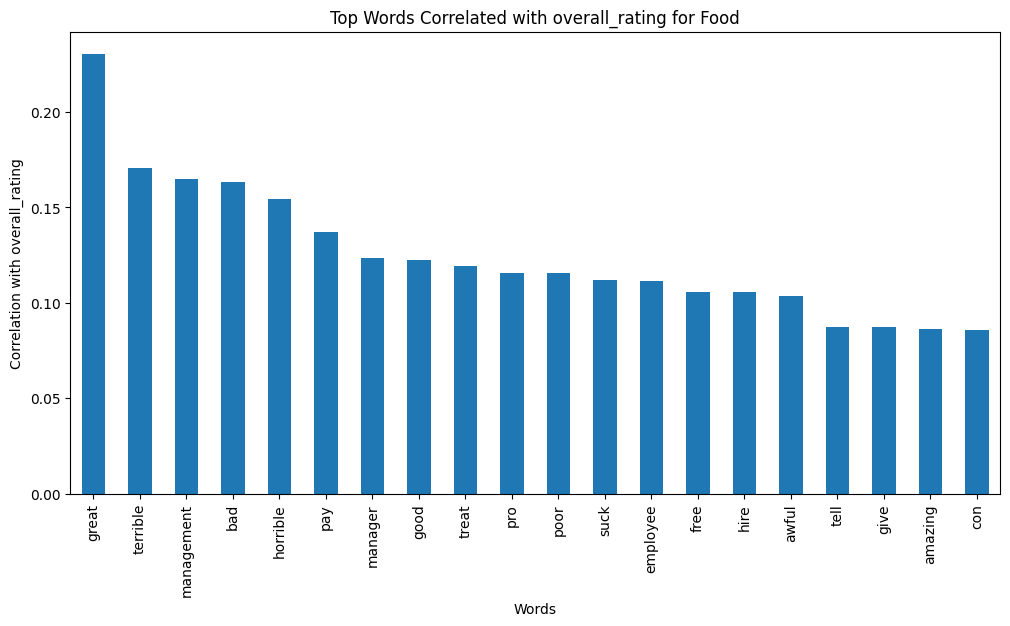

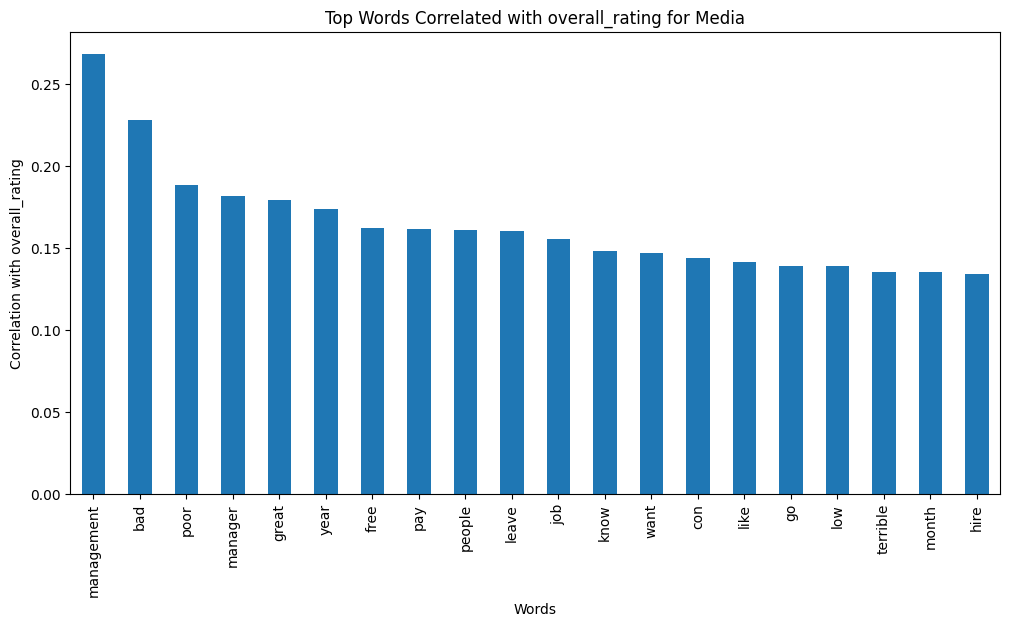

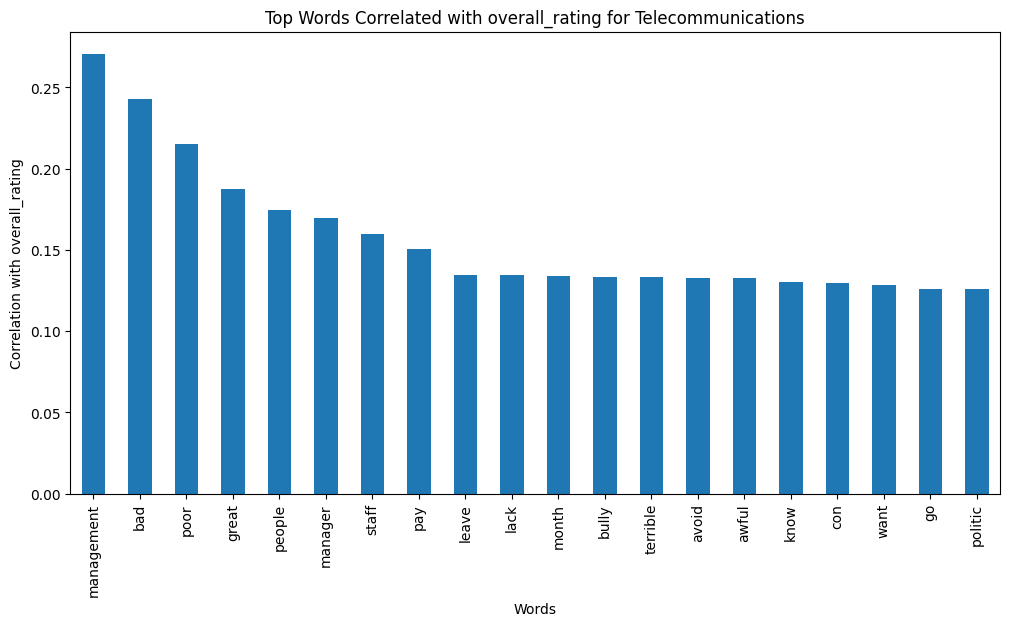

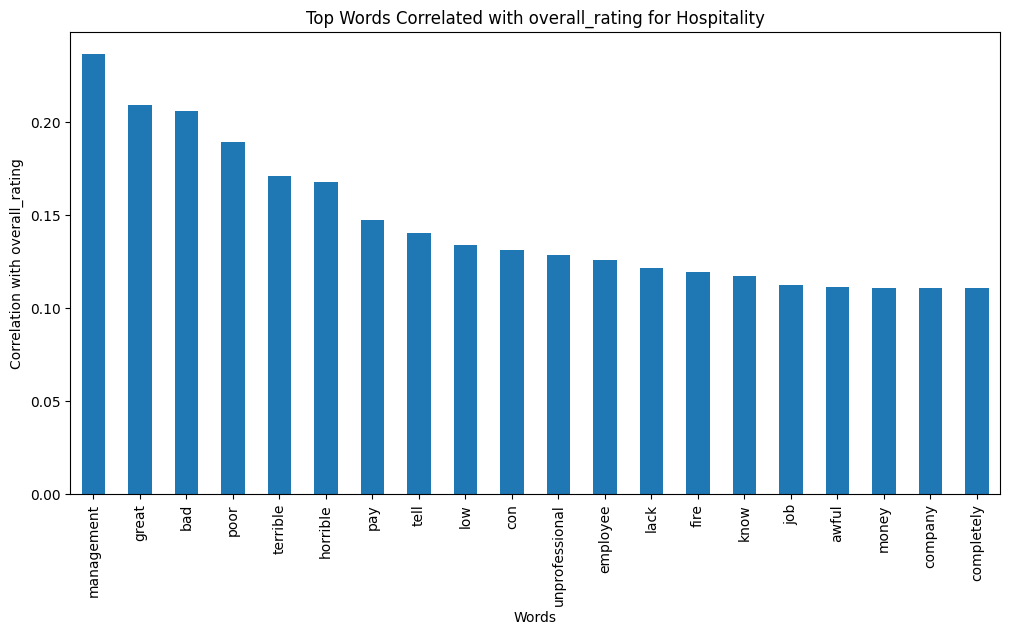

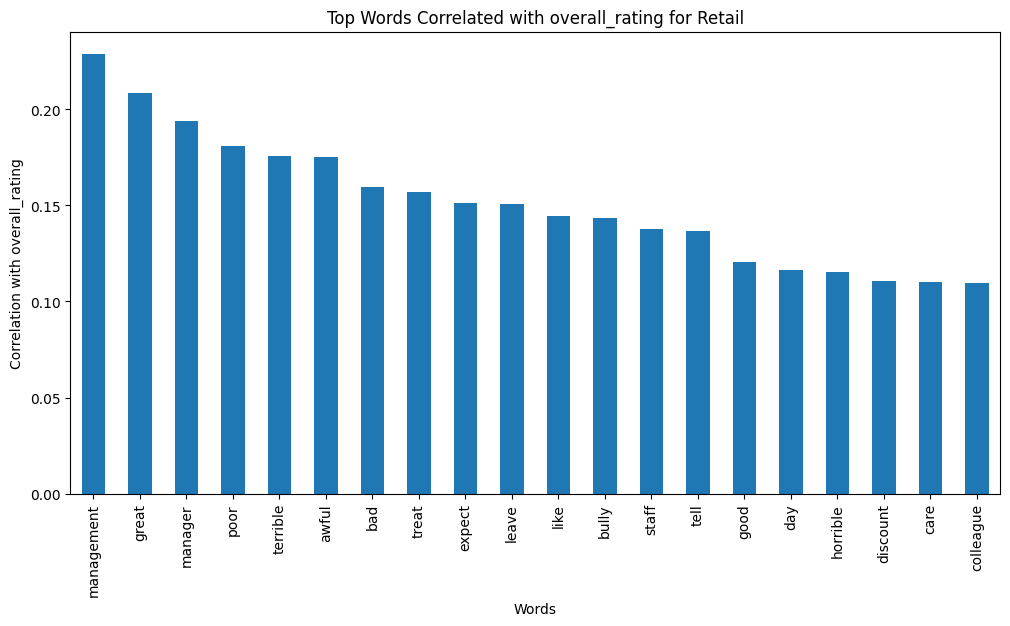

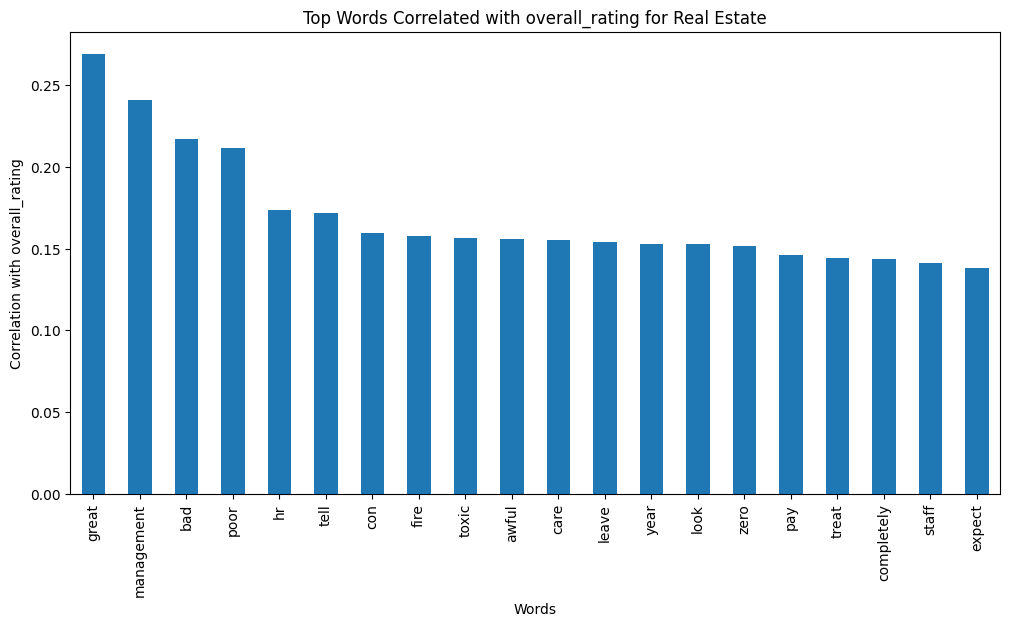

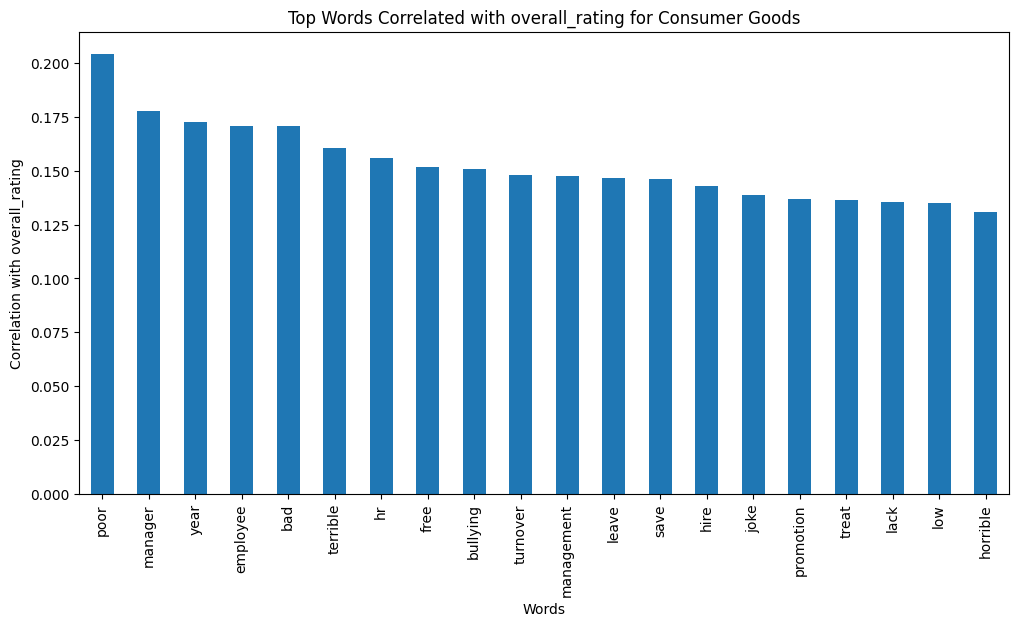

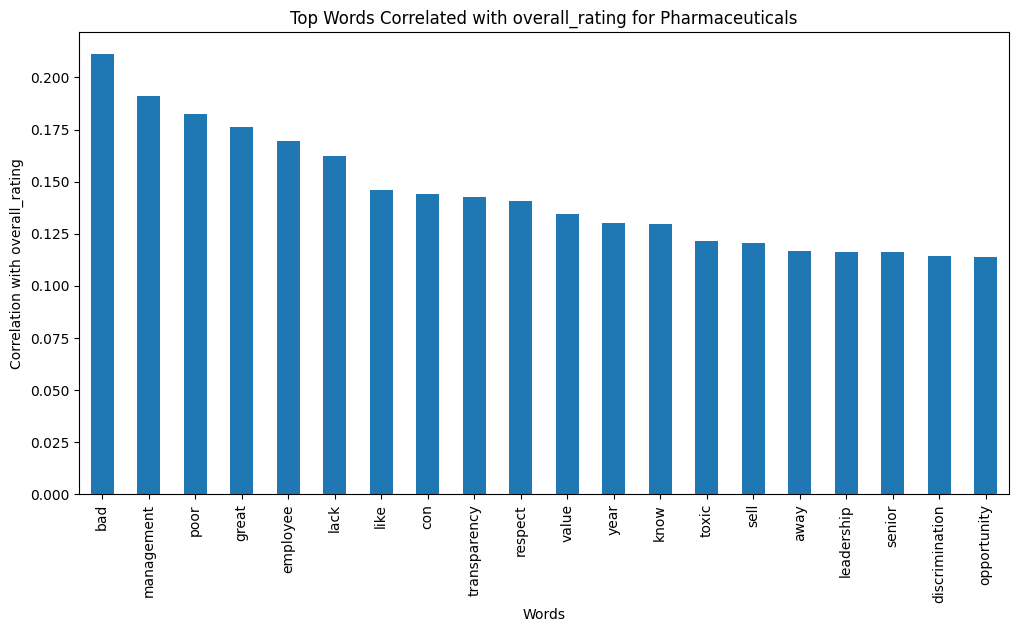

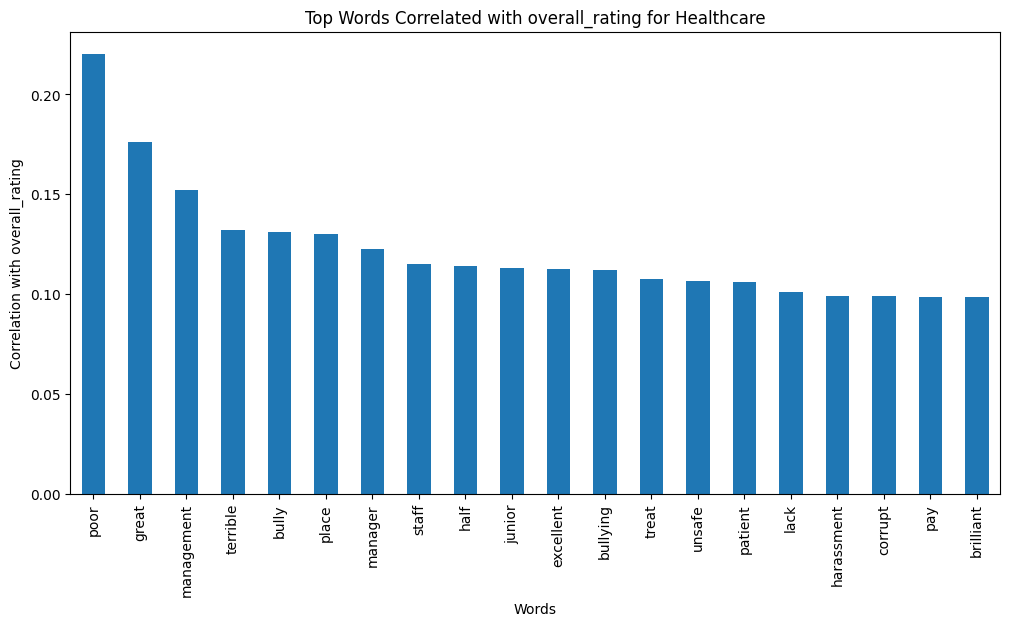

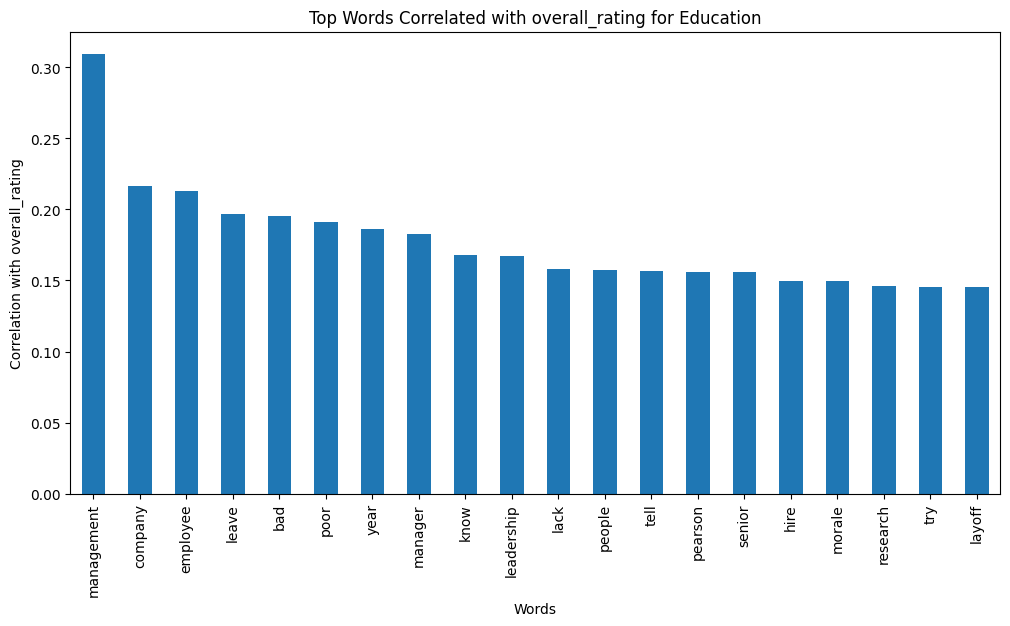

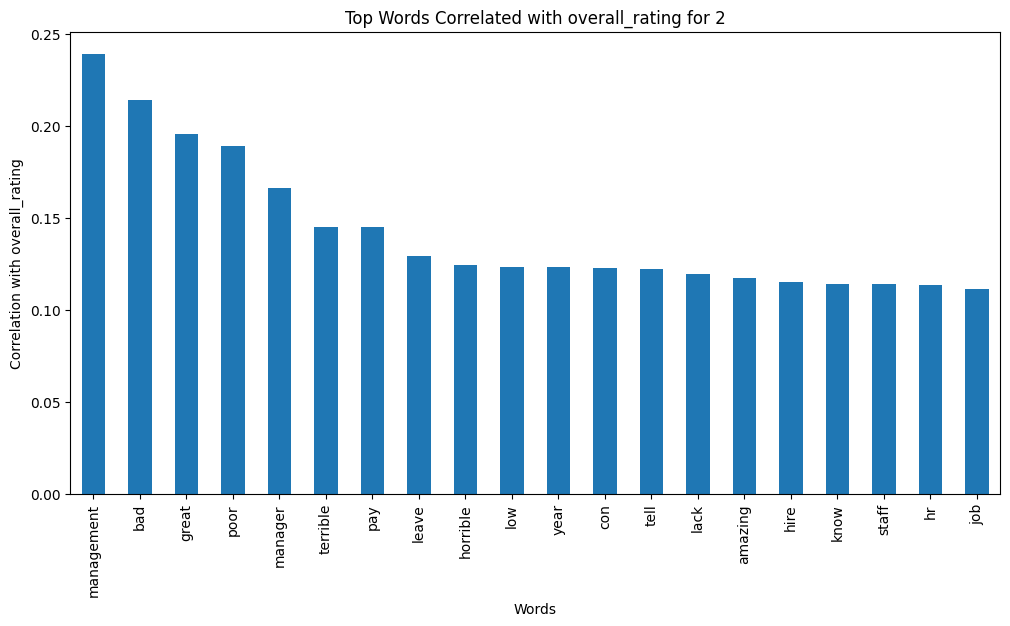

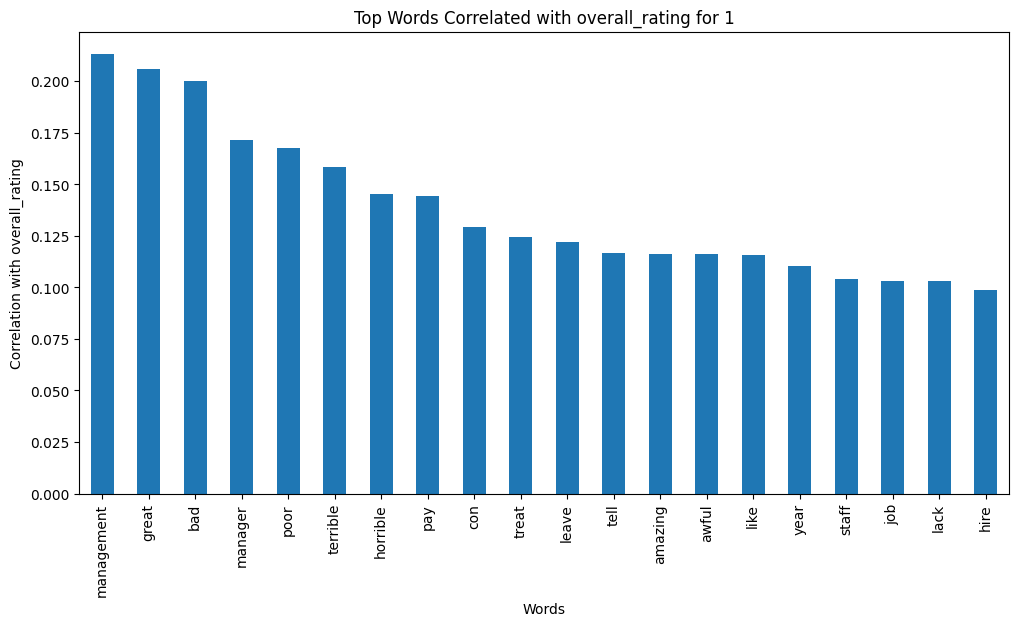

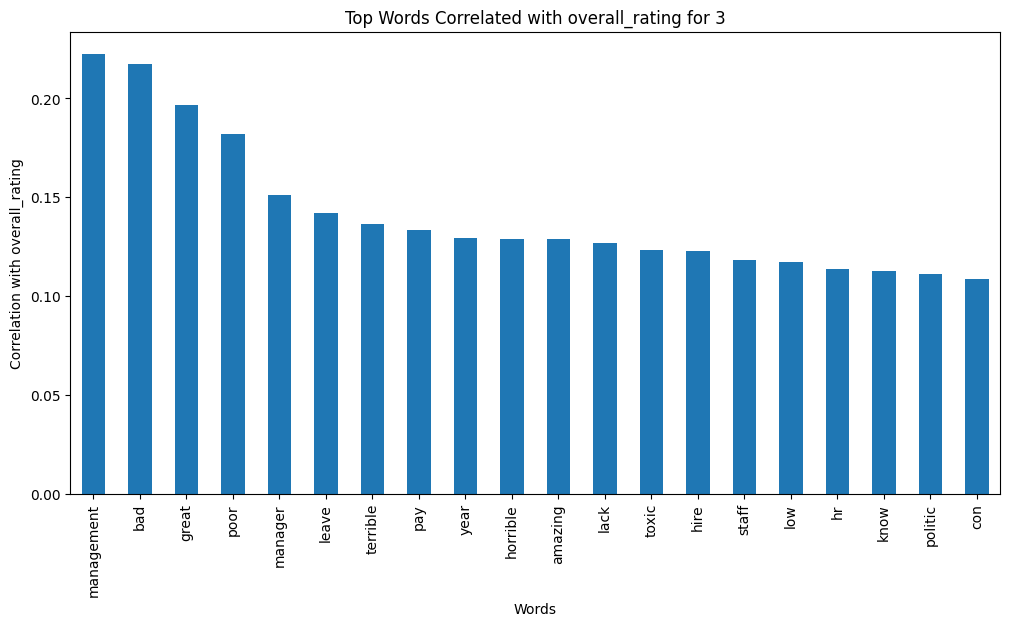

In [283]:
# function to compute and plot word correlations
def word_correlation_by_category(df, category_col, category_value, text_col, rating_col):
    subset = df[df[category_col] == category_value]
    
    word_vectorizer = CountVectorizer(max_features=1000)
    X_words = word_vectorizer.fit_transform(subset[text_col])
    word_features = pd.DataFrame(X_words.toarray(), columns=word_vectorizer.get_feature_names_out())
    
    # zero-variance columns -> causing divide 0 errors
    word_features = word_features.loc[:, (word_features != 0).any(axis=0)]

    correlation = word_features.apply(lambda col: np.corrcoef(col, subset[rating_col])[0, 1])
    
    correlation = correlation.dropna()
    
    # Plot the top correlated words
    top_correlated_words = correlation.abs().sort_values(ascending=False).head(20)
    top_correlated_words.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Top Words Correlated with {rating_col} for {category_value}')
    plt.xlabel('Words')
    plt.ylabel(f'Correlation with {rating_col}')
    plt.show()

# Correlation analysis by industry
industries = df['industry'].unique()
for industry in industries:
    word_correlation_by_category(df, 'industry', industry, 'processed_text', 'overall_rating')

# Correlation analysis by management level
levels = df['level'].unique()
for level in levels:
    word_correlation_by_category(df, 'level', level, 'processed_text', 'overall_rating')

## 3.4 Summary <a id = '3_4'></a>

- Overall Observations
    - Job Hiearchy does not contribute to overall rating, it seems to be all flat throughout in most industries except food/retail (lower level has much worse experience)
    - 
- Industry/Job Level Trends
    - Diffe
    - Higher job levels (Senior management) does not seem to effect overall_ratings as much as expected
    - 

- Potential Problems
    - Not enough firms that represents an industry (consumer goods, healthcare, realestate, etc)
    - 

## 3.5 Exports

In [288]:
import os

data_folder = 'CleanedData'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

cleaned_data_path = os.path.join(data_folder, 'clean_data_2.csv')

df.to_csv(cleaned_data_path, index=False)